##### Vladislav Gorokhov

# Bitcoin Price Modeling and Forecasting

## Part 1. Modelling and forecasting using time series analysis and econometrics techniques

In [1]:
load('./case_BTC.RData')

### Loading data

In [2]:
BTC <- read.csv('./data/CBBTCUSD.csv')
BTC['CBBTCUSD'] <- sapply(BTC['CBBTCUSD'], as.numeric)
BTC$DATE <- as.Date(BTC$DATE, format='%Y-%m-%d')

print(head(BTC, 10), row.names=FALSE)

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


       DATE CBBTCUSD
 2017-02-15  1014.53
 2017-02-16  1038.94
 2017-02-17  1057.30
 2017-02-18  1062.15
 2017-02-19  1059.88
 2017-02-20  1089.82
 2017-02-21  1128.29
 2017-02-22  1128.71
 2017-02-23  1186.90
 2017-02-24  1186.91


We have daily data without passes, surveyed by weekends or holidays.

### Data preprocessing

Check the data for error values

In [3]:
sum(is.na(BTC['CBBTCUSD']))

[1] 1

We have only one gap.  
Fill it with the previous value

In [4]:
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [5]:
BTC <- BTC %>%
    mutate(CBBTCUSD=ifelse(is.na(CBBTCUSD), CBBTCUSD[which(is.na(CBBTCUSD)) - 1], CBBTCUSD))

Let's get descriptive statistics of the series

In [6]:
library(skimr)
library(psych)


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha




In [7]:
print(describe(BTC$CBBTCUSD))

   vars    n     mean       sd  median  trimmed     mad    min      max
X1    1 1827 16497.32 17311.02 8892.39 13432.95 5534.37 934.87 67510.06
      range skew kurtosis  se
X1 66575.19  1.4     0.52 405


The distribution of the series has a right-hand asymmetry, since the coefficient of asymmetry is 1.4, and the excess of the distribution of 0.52 lies within the permissible range [-1; 1] of deviation from the normal distribution.

In [8]:
fix_windows_histograms()
skim(BTC$CBBTCUSD)
Sys.setlocale("LC_CTYPE", "russian")

This function will change your system locale. It may have other unintended effects.



,skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,numeric,CBBTCUSD,0,1,16497.32,17311.02,934.87,6191.51,8892.39,17734.39,67510.06,▇▁▁▁▁


-- Data Summary ------------------------
                           Values      
Name                       BTC$CBBTCUSD
Number of rows             1827        
Number of columns          1           
_______________________                
Column type frequency:                 
  numeric                  1           
________________________               
Group variables            None        

-- Variable type: numeric ------------------------------------------------------
  skim_variable n_missing complete_rate   mean     sd   p0   p25   p50    p75
1 CBBTCUSD              0             1 16497. 17311. 935. 6192. 8892. 17734.
    p100 hist 
1 67510. ▇▁▁▁▁


[1] "Russian_Russia.1251"

We have T = 1827 observations. There are no gaps in the data after their filling.

Plot the density function of the series distribution

In [9]:
library(ggplot2)
library(ggfortify)

In [10]:
fig <- function(width, heigth, dpi=110) {
  options(repr.plot.width=width, repr.plot.height=heigth, repr.plot.res=dpi)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



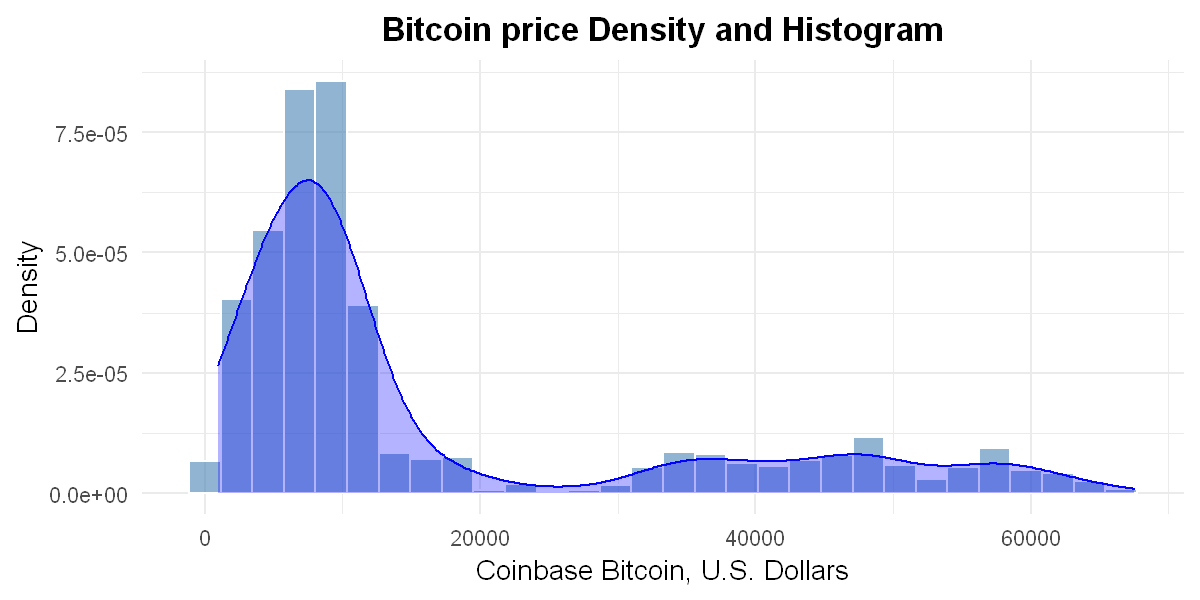

In [11]:
fig(6, 3, 200)
ggplot(BTC, aes(CBBTCUSD)) +
    geom_histogram(aes(y=..density..), position='identity', fill='steelblue', col='white', alpha=.6) +
    geom_density(fill='blue', col='blue', alpha=.3, adjust=1.75) +
    xlab('Coinbase Bitcoin, U.S. Dollars') +
    ylab('Density') +
    ggtitle('Bitcoin price Density and Histogram') +
    theme_minimal() +
    theme(plot.title=element_text(hjust=.5, size=12, face='bold'),
          axis.title=element_text(size=10),
          axis.text.x=element_text(size=8),
          axis.text.y=element_text(size=8))

The distribution of the data series is multimodal.

We will use the last 400 observations of the series for modelling the daily data

In [12]:
BTC_daily <- BTC[1428:1827, ]

Get statistical characteristics for truncated data

In [13]:
print(describe(BTC_daily$CBBTCUSD))

   vars   n     mean      sd   median  trimmed      mad      min      max
X1    1 400 47064.99 9404.45 47077.87 46927.09 12847.49 29788.61 67510.06
      range skew kurtosis     se
X1 37721.45 0.09    -1.07 470.22


The distribution has a small left-hand asymmetry and an excessive negative kurtosis, which slightly exceeds the possible deviations [-1; 1].  

Distribution plot of the truncated data

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



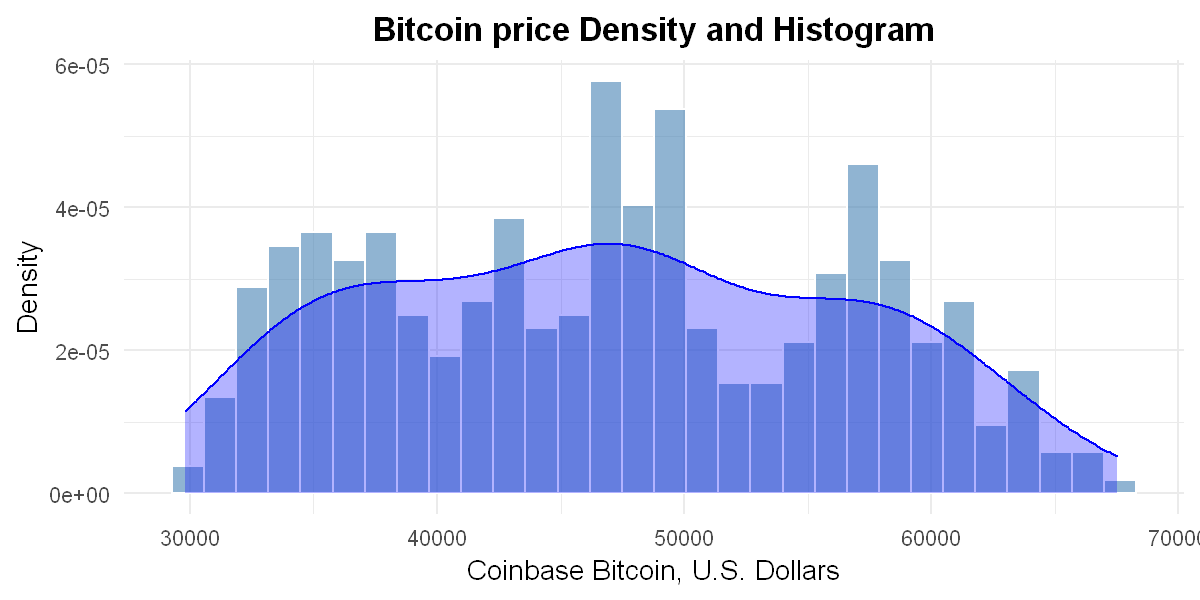

In [14]:
fig(6, 3, 200)
ggplot(BTC_daily, aes(CBBTCUSD)) +
    geom_histogram(aes(y=..density..), position='identity', fill='steelblue', col='white', alpha=.6) +
    geom_density(fill='blue', col='blue', alpha=.3, adjust=1.45) +
    xlab('Coinbase Bitcoin, U.S. Dollars') +
    ylab('Density') +
    ggtitle('Bitcoin price Density and Histogram') +
    theme_minimal() +
    theme(plot.title=element_text(hjust=.5, size=12, face='bold'),
          axis.title=element_text(size=10),
          axis.text.x=element_text(size=8),
          axis.text.y=element_text(size=8))

Distribution is multimodal.

Since data are not distributed normally, we cannot use robust statistical methods to test for gross errors in data. Let's check the data for outstanding values (outliers) by box-plot

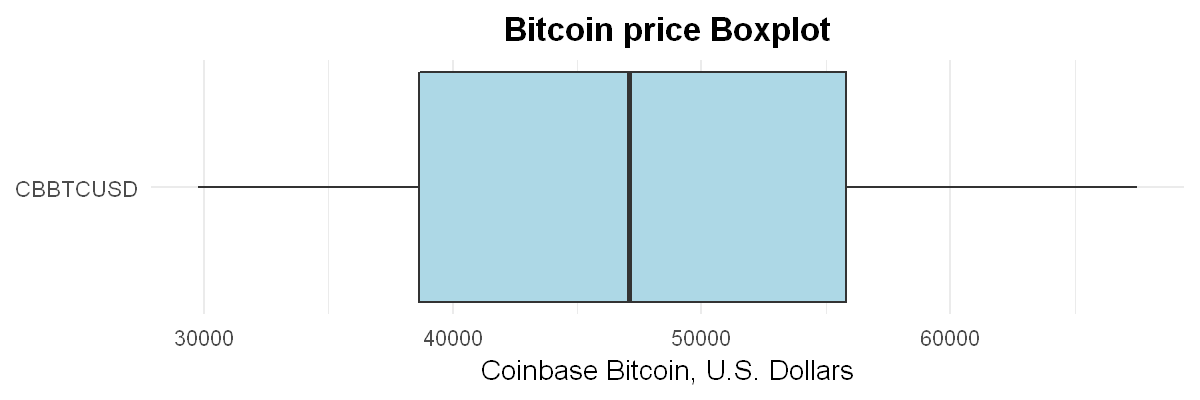

In [15]:
fig(6, 2, 200)
ggplot(data.frame(BTC_daily), aes(CBBTCUSD)) +
    geom_boxplot(fill='lightblue', outlier.colour='black', outlier.shape=16, outlier.size=2.2) +
    scale_y_continuous(breaks=0, labels='CBBTCUSD') +
    xlab('Coinbase Bitcoin, U.S. Dollars') +
    ggtitle('Bitcoin price Boxplot') +
    theme_minimal() +
    theme(plot.title=element_text(hjust=.5, size=12, face='bold'),
          axis.title=element_text(size=10),
          axis.text.x=element_text(size=8),
          axis.text.y=element_text(size=8))

There are no outliers.

### Time series structure analysis

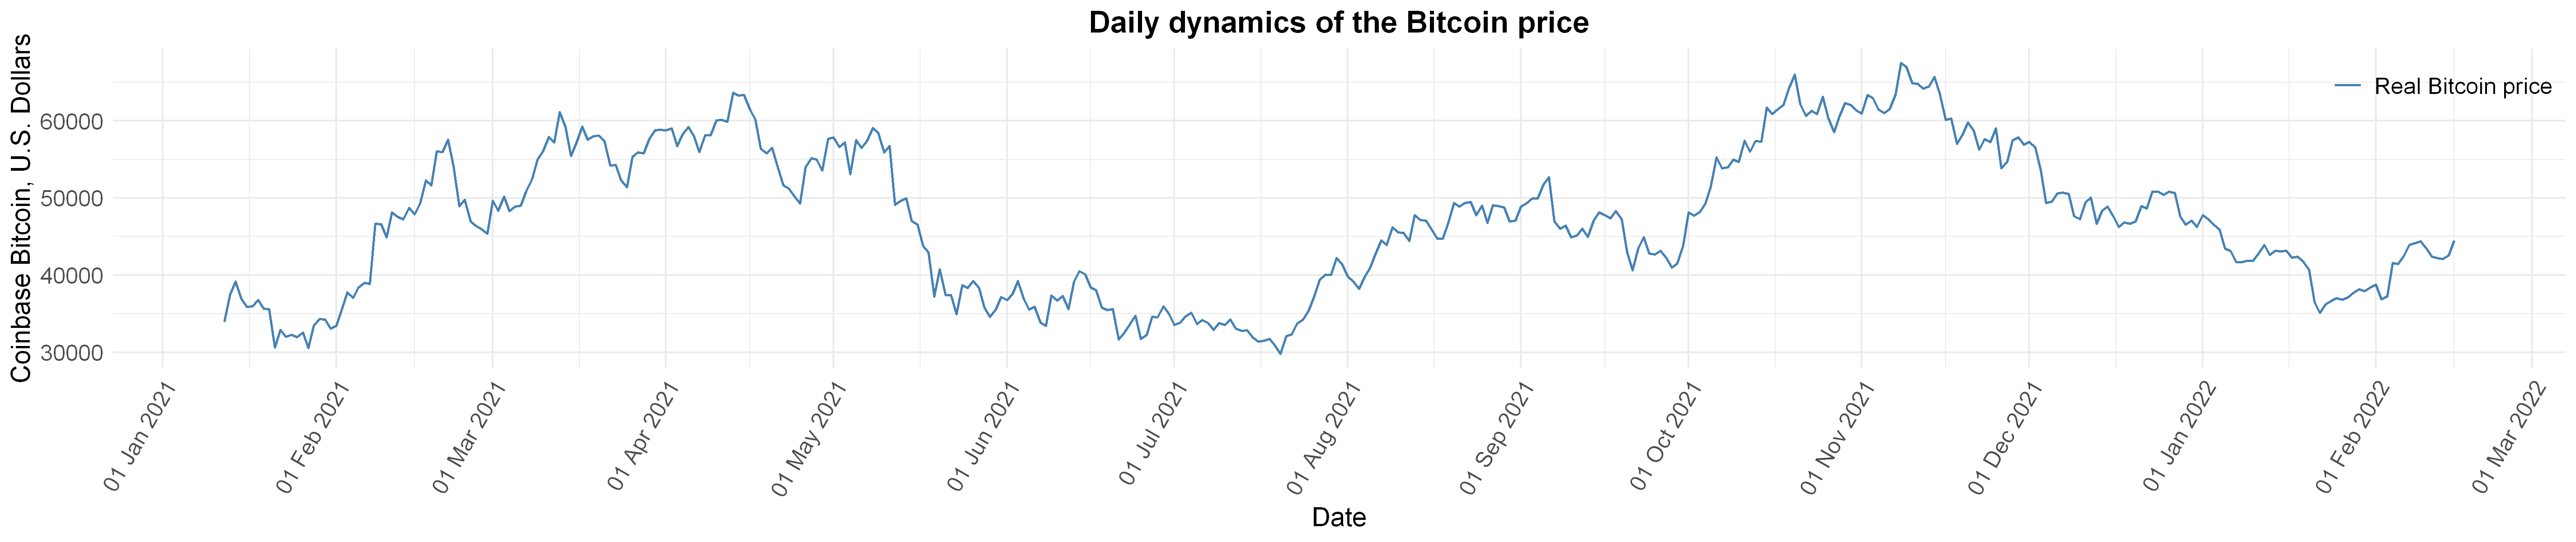

In [16]:
daily.plot <- ggplot(BTC_daily, aes(DATE)) +
    geom_line(aes(y=CBBTCUSD, colour='Real Bitcoin price'), size=0.6) +
    xlab('Date') +
    ylab('Coinbase Bitcoin, U.S. Dollars') +
    ggtitle('Daily dynamics of the Bitcoin price') +
    scale_y_continuous(breaks=seq(30000, 70000, 10000),
                       labels=seq(30000, 70000, 10000)) +
    scale_x_date(date_breaks='1 month',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2021-01-12'), as.Date('2022-02-15'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(angle=60, hjust=1, size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14),
          legend.text=element_text(size=12),
          legend.justification=c(1, 1),
          legend.position=c(1, 1),
          legend.title=element_blank()) +
    scale_color_manual(name='', values=c('Real Bitcoin price'='steelblue'))

fig(19, 4, 300)
daily.plot

To identify the current trend we can use the exponential smoothing

In [17]:
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method                 from     
  autoplot.Arima         ggfortify
  autoplot.acf           ggfortify
  autoplot.ar            ggfortify
  autoplot.bats          ggfortify
  autoplot.decomposed.ts ggfortify
  autoplot.ets           ggfortify
  autoplot.forecast      ggfortify
  autoplot.stl           ggfortify
  autoplot.ts            ggfortify
  fitted.ar              ggfortify
  fortify.ts             ggfortify
  residuals.ar           ggfortify



In [18]:
BTC_daily_ses <- c(NA, ses(BTC_daily$CBBTCUSD, alpha=0.015, initial='simple')$model$fitted[-1])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


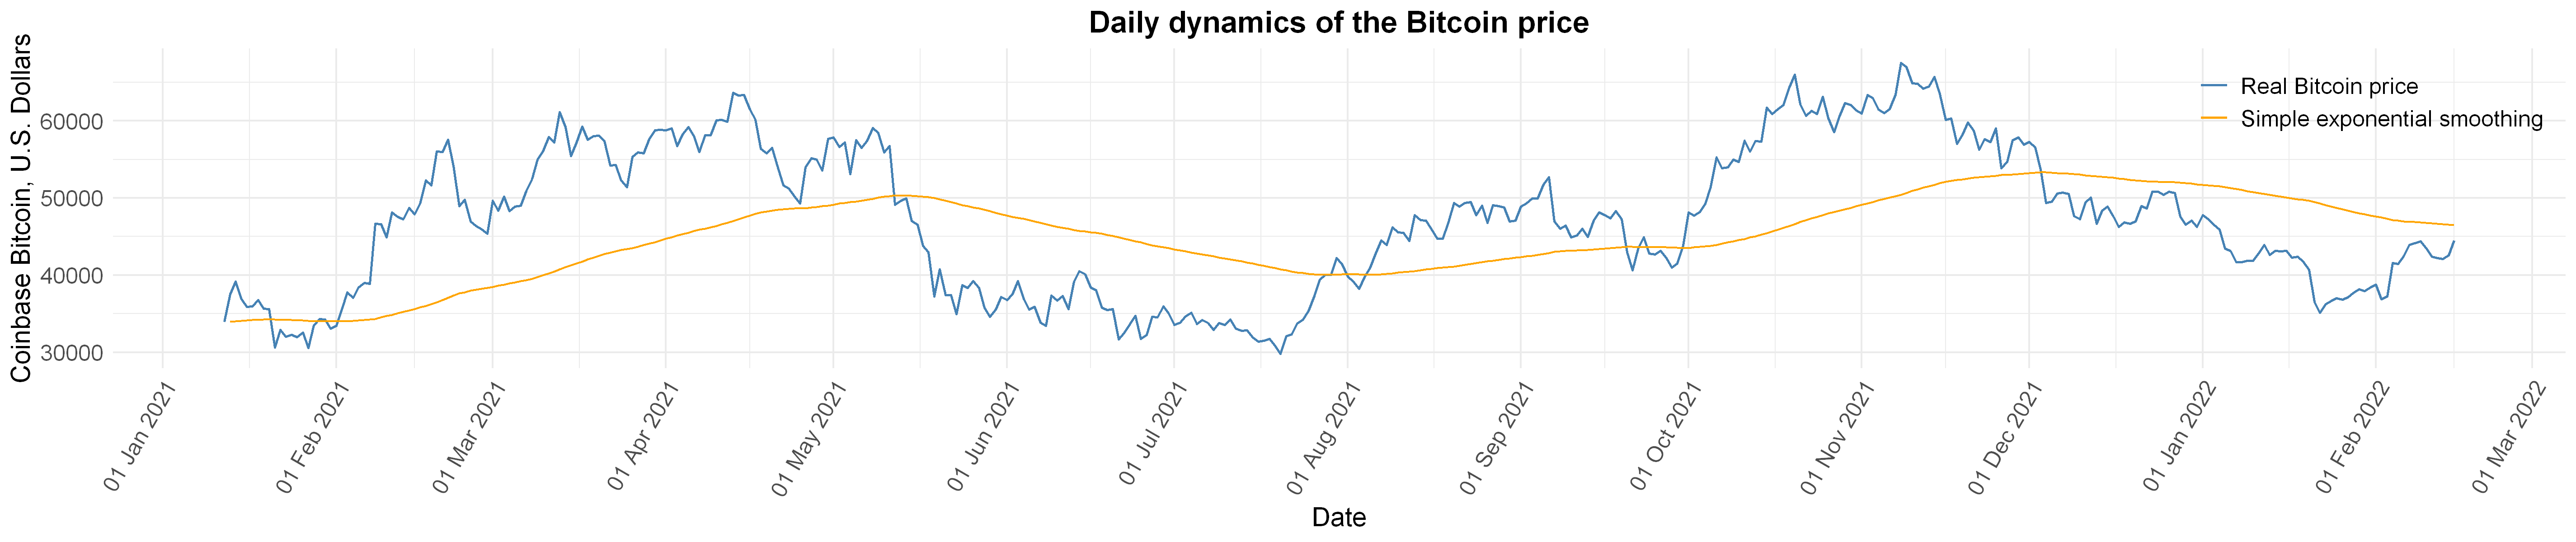

In [19]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=BTC_daily_ses, colour='Simple exponential smoothing')) +
    scale_color_manual(name='', values=c('Real Bitcoin price'='steelblue', 'Simple exponential smoothing'='orange'))

There is a general upward trend. There is both a deterministic and a stochastic trend.

### Stationarity testing

#### 1. Constant mean

##### Mann-Whitney test

Because the data are not distributed normally, we apply the Mann-Whitney non-parametric criterion

In [20]:
wilcox.test(BTC_daily$CBBTCUSD[1:200], BTC_daily$CBBTCUSD[201:400], alternative='two.sided', paired=FALSE)


	Wilcoxon rank sum test with continuity correction

data:  BTC_daily$CBBTCUSD[1:200] and BTC_daily$CBBTCUSD[201:400]
W = 14365, p-value = 1.096e-06
alternative hypothesis: true location shift is not equal to 0


The calculated statistics are significant, as indicated by the p-value. The test rejects the null hypothesis of the constancy of the time series expectation.

#### 2. Constant variance

##### Siegel-Tukey test

Because the data are not distributed normally, we apply the non-parametric Siegel-Tukey criterion

In [21]:
library(DescTools)


Attaching package: 'DescTools'


The following object is masked from 'package:forecast':

    BoxCox


The following objects are masked from 'package:psych':

    AUC, ICC, SD




In [22]:
SiegelTukeyTest(BTC_daily$CBBTCUSD[1:200], BTC_daily$CBBTCUSD[201:400], alternative='two.sided')


	Siegel-Tukey-test for equal variability

data:  BTC_daily$CBBTCUSD[1:200] and BTC_daily$CBBTCUSD[201:400]
ST = 32155, p-value = 6.351e-12
alternative hypothesis: true ratio of scales is not equal to 1


The p-value for the calculated statistics is less than 0.5, so we reject the hypothesis of the constancy of the variance of the two parts of the series.

#### 3. Uncorrelated series levels

Let's calculate some sampled and partial autocorrelation coefficients and plot ACF and PACF of the series

In [23]:
acf(BTC_daily$CBBTCUSD, lag.max=12, pl=FALSE)


Autocorrelations of series 'BTC_daily$CBBTCUSD', by lag

    0     1     2     3     4     5     6     7     8     9    10    11    12 
1.000 0.978 0.959 0.941 0.921 0.899 0.877 0.854 0.834 0.815 0.792 0.767 0.742 

In [24]:
pacf(BTC_daily$CBBTCUSD, lag.max=12, pl=FALSE)


Partial autocorrelations of series 'BTC_daily$CBBTCUSD', by lag

     1      2      3      4      5      6      7      8      9     10     11 
 0.978  0.059  0.021 -0.049 -0.068 -0.034 -0.017  0.052  0.024 -0.106 -0.057 
    12 
-0.031 

In [25]:
library(tsm)

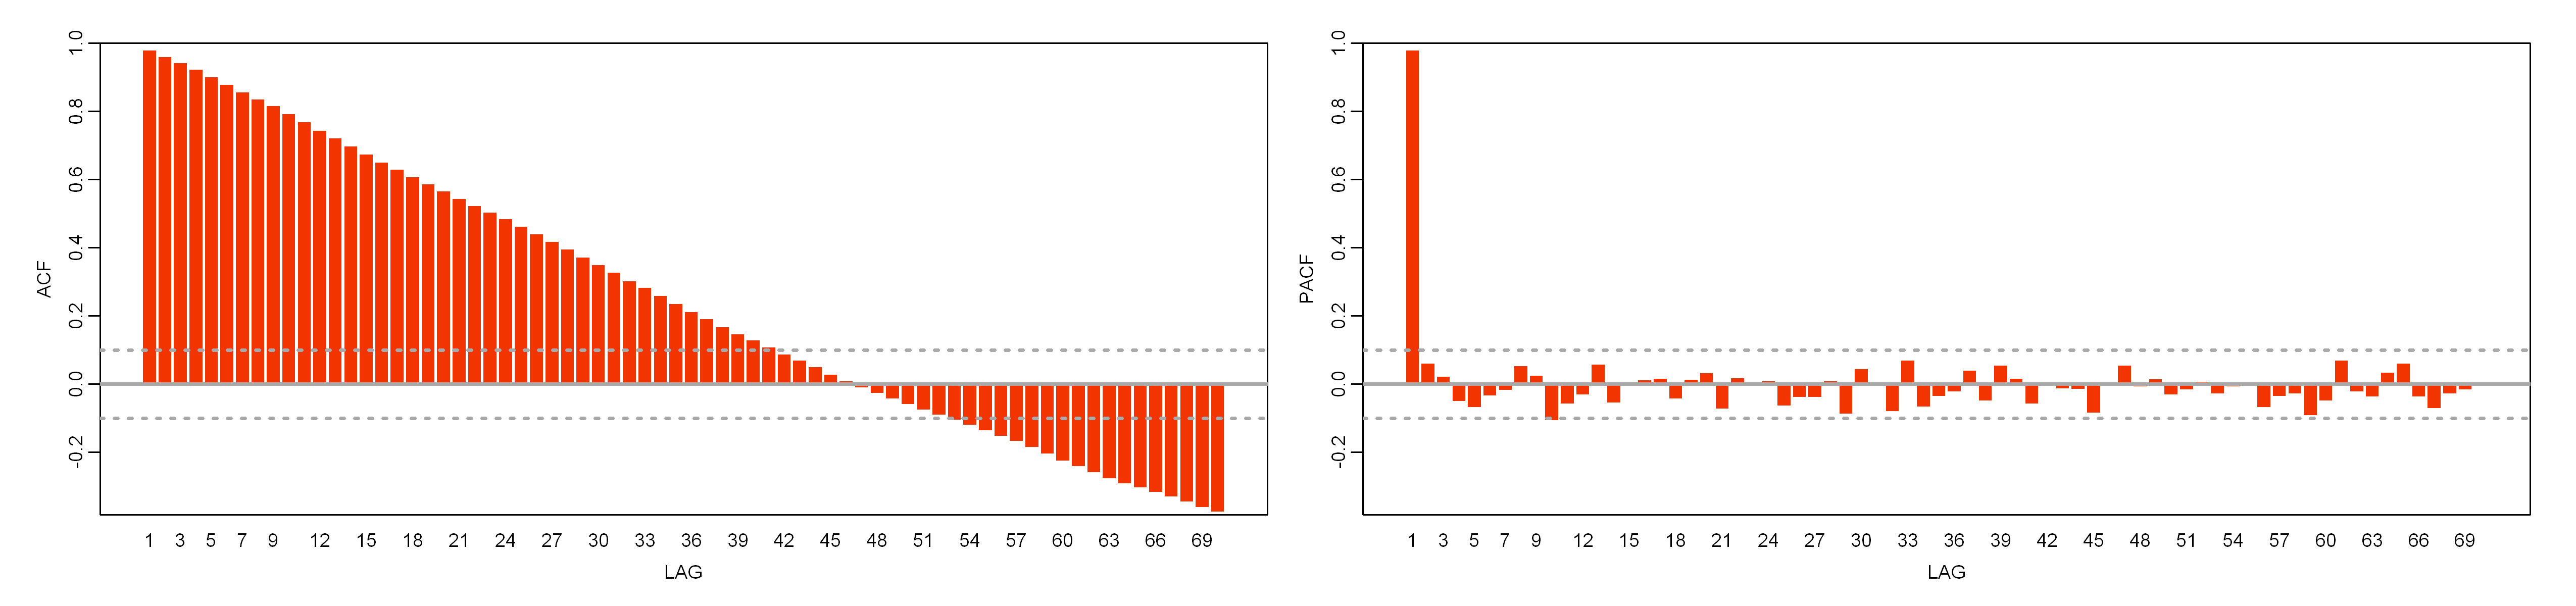

In [26]:
fig(17, 4, 300)
ac(BTC_daily$CBBTCUSD, max.lag=70)

Obviously, the value of the autocovariance coefficient for this process depends on the moment of time t, not just the lag. The values of the selected autocorrelation coefficients gradually decrease to zero. This also confirms the non-stationarity of the process.  
PACF breaks at lag 1, and the value of the partial autocorrelation coefficient for lag 1 is close to 1. Therefore, we have a non-stationary autoregressive process of order 1.

The time series is non-stationary (belonging to the linear non-stationary ARIMA models class). The behavior of the series is determined by two non-stationary components: a deterministic trend with drift μ (PACF gradually decreases into the negative area) and a stochastic trend. There is no cyclicity.  
The possible model is $y_t = α_0 + α_1 \cdot y_{t-1} + ε_t$.
It is obvious that $α_1 = 1$ (see ACF, PACF and series plot) and the process is a random walk with trend and drift. And we’re probably dealing with a submartingale.

#### Unit root tests

Because the data has a distribution other than normal, the augmented Dickey-Fuller test related to parametric tests cannot be applied. As an alternative to this test, we use the non-parametric Phillips-Perron test, which is resistant to ambiguous autocorrelation and heteroskedasticity

In [27]:
library(tseries)

In [28]:
pp.test(BTC_daily$CBBTCUSD, alternative='stationary', type='Z(t_alpha)')


	Phillips-Perron Unit Root Test

data:  BTC_daily$CBBTCUSD
Dickey-Fuller Z(t_alpha) = -2.1666, Truncation lag parameter = 5,
p-value = 0.5069
alternative hypothesis: stationary


The test allows us to accept the null non-stationarity hypothesis of the series, since the p-value of the calculated statistics is biiger than 0.5. Therefore, the series is a random walk process.

For further modelling, the series must be stationary.

### Making time series stationary

Let's move on to the logarithmic returns series

In [29]:
BTC_daily_logret <- diff(log(BTC_daily$CBBTCUSD), differences=1)

Log-returns plot

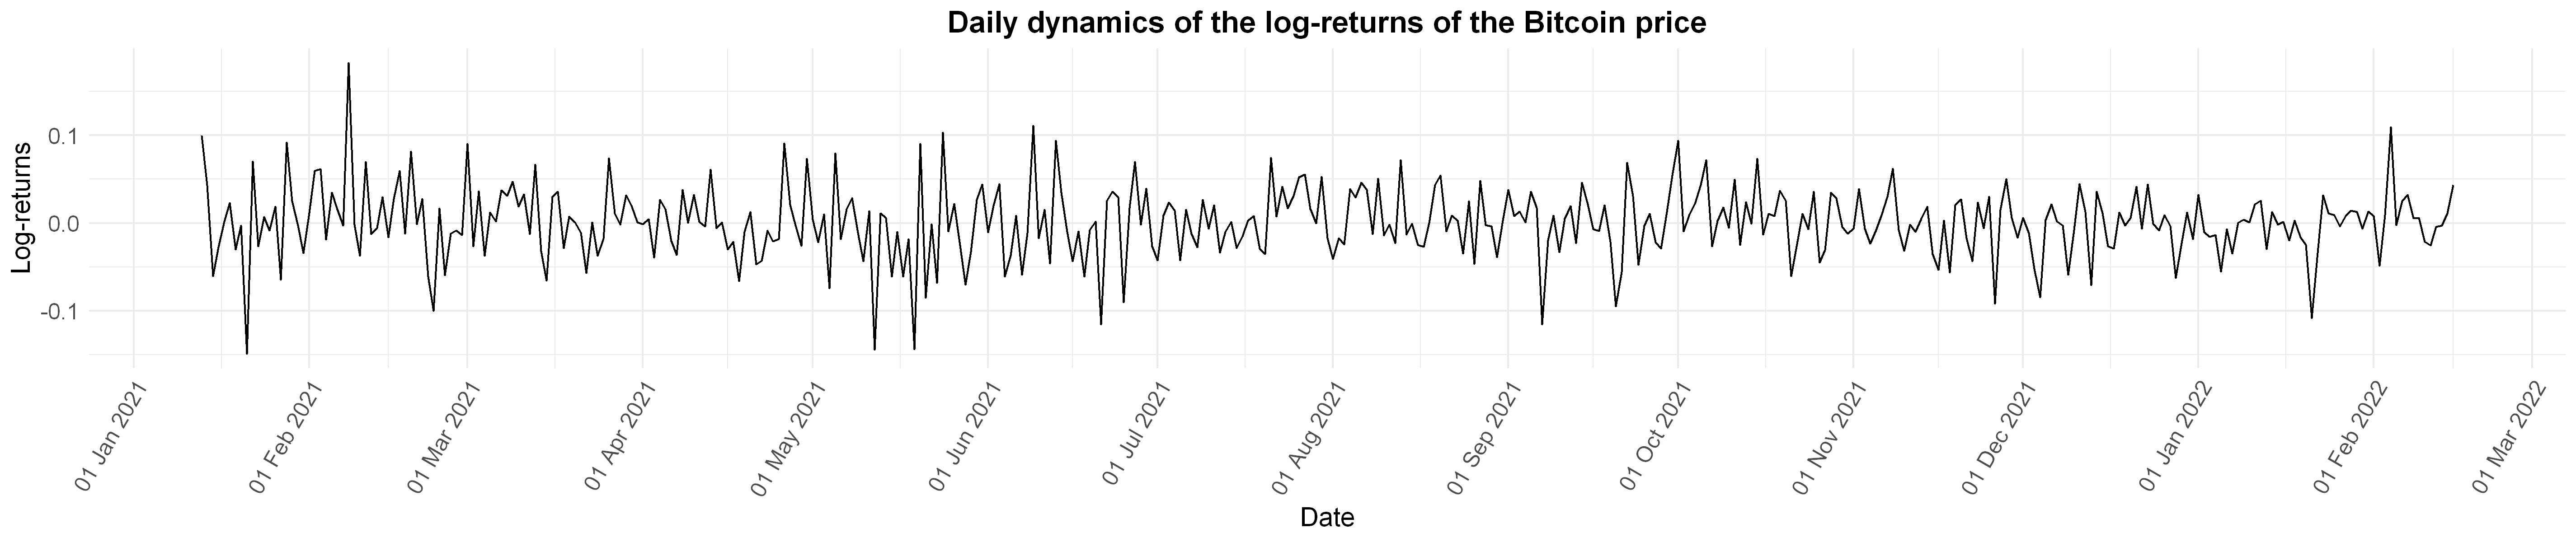

In [30]:
fig(19, 4, 300)
ggplot(BTC_daily[-1, ], aes(DATE, BTC_daily_logret)) +
    geom_line() +
    xlab('Date') +
    ylab('Log-returns') +
    ggtitle('Daily dynamics of the log-returns of the Bitcoin price') +
    scale_x_date(date_breaks='1 month',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2021-01-13'), as.Date('2022-02-15'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(angle=60, hjust=1, size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14))

Let's get descriptive statistics of the series

In [31]:
stats_BTC_daily_logret <- describe(BTC_daily_logret)
print(stats_BTC_daily_logret)

   vars   n mean   sd median trimmed  mad   min  max range  skew kurtosis se
X1    1 399    0 0.04      0       0 0.03 -0.15 0.18  0.33 -0.08     1.98  0


The series distribution has a high kurtosis value exceeding the possible interval [-1; 1].

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



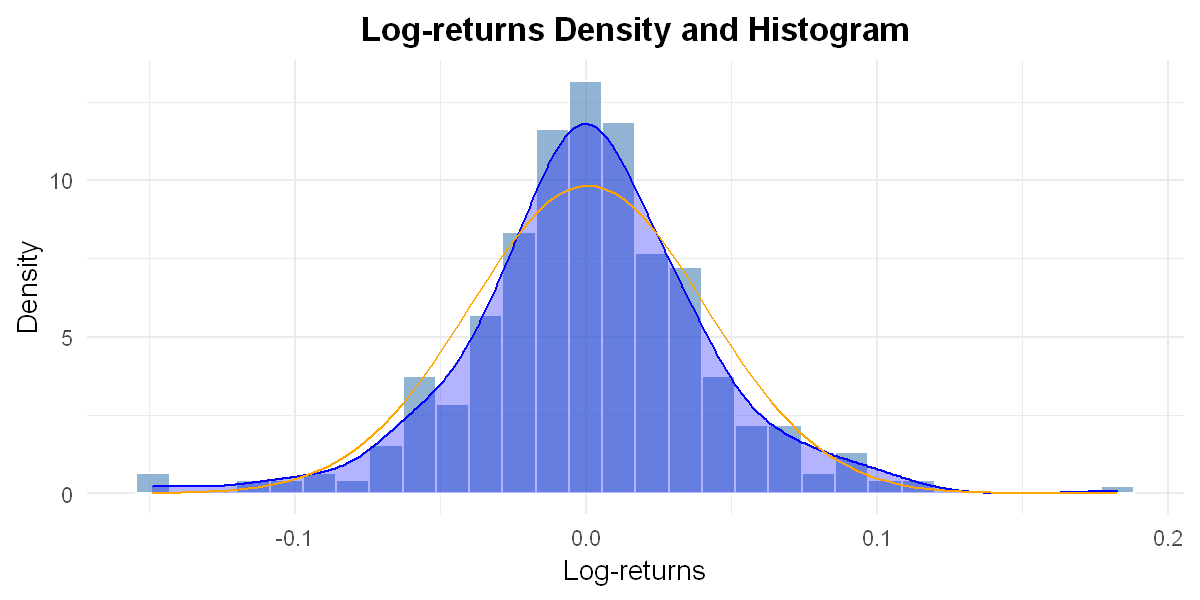

In [32]:
fig(6, 3, 200)
ggplot(BTC_daily[-1, ], aes(BTC_daily_logret)) +
    geom_histogram(aes(y=..density..), position='identity', fill='steelblue', col='white', alpha=.6) +
    geom_density(fill='blue', col='blue', alpha=.3, adjust=1.45) +
    stat_function(fun=dnorm, args=list(mean=stats_BTC_daily_logret$mean, sd=stats_BTC_daily_logret$sd), col='orange') +
    xlab('Log-returns') +
    ylab('Density') +
    ggtitle('Log-returns Density and Histogram') +
    theme_minimal() +
    theme(plot.title=element_text(hjust=.5, size=12, face='bold'),
          axis.title=element_text(size=10),
          axis.text.x=element_text(size=8),
          axis.text.y=element_text(size=8))

[1] 27  9

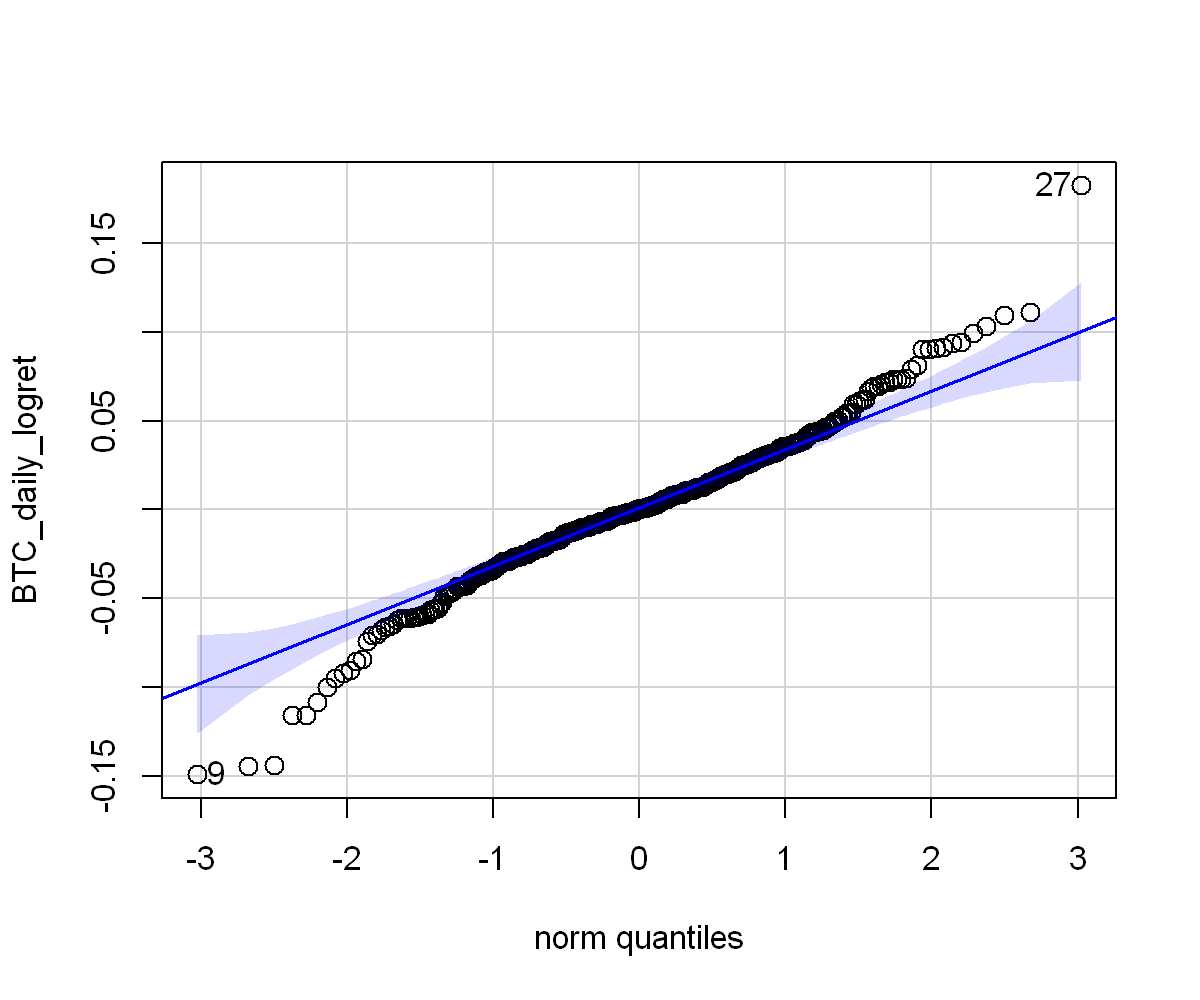

In [33]:
fig(6, 5, 200)
car::qqPlot(BTC_daily_logret,
            cex=1.3, lwd=1.8,
            envelope=list(border=FALSE))

The distribution of the log-returns series differs from normal.

Let’s test log-returns series for stationarity using non-parametric tests

#### 1. Constant mean

##### Mann-Whitney test

In [34]:
wilcox.test(BTC_daily_logret[1:200], BTC_daily_logret[201:399], alternative='two.sided', paired=FALSE)


	Wilcoxon rank sum test with continuity correction

data:  BTC_daily_logret[1:200] and BTC_daily_logret[201:399]
W = 19773, p-value = 0.9125
alternative hypothesis: true location shift is not equal to 0


The expectation of a series is constant.

#### 2. Constant variance

##### Siegel-Tukey test

In [35]:
SiegelTukeyTest(BTC_daily_logret[1:200], BTC_daily_logret[201:399], alternative='two.sided')


	Siegel-Tukey-test for equal variability

data:  BTC_daily_logret[1:200] and BTC_daily_logret[201:399]
ST = 3176, p-value = 0.08378
alternative hypothesis: true ratio of scales is not equal to 1


The variances of the two parts of log-returns series are statistically equal.

#### 3. Uncorrelated series levels

In [36]:
acf(BTC_daily_logret, lag.max=12, pl=FALSE)


Autocorrelations of series 'BTC_daily_logret', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.060 -0.007  0.010  0.075 -0.002  0.029 -0.070 -0.044  0.065  0.053 
    11     12 
 0.006 -0.090 

In [37]:
pacf(BTC_daily_logret, lag.max=12, pl=FALSE)


Partial autocorrelations of series 'BTC_daily_logret', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.060 -0.011  0.009  0.076  0.007  0.031 -0.069 -0.059  0.057  0.058  0.026 
    12 
-0.084 

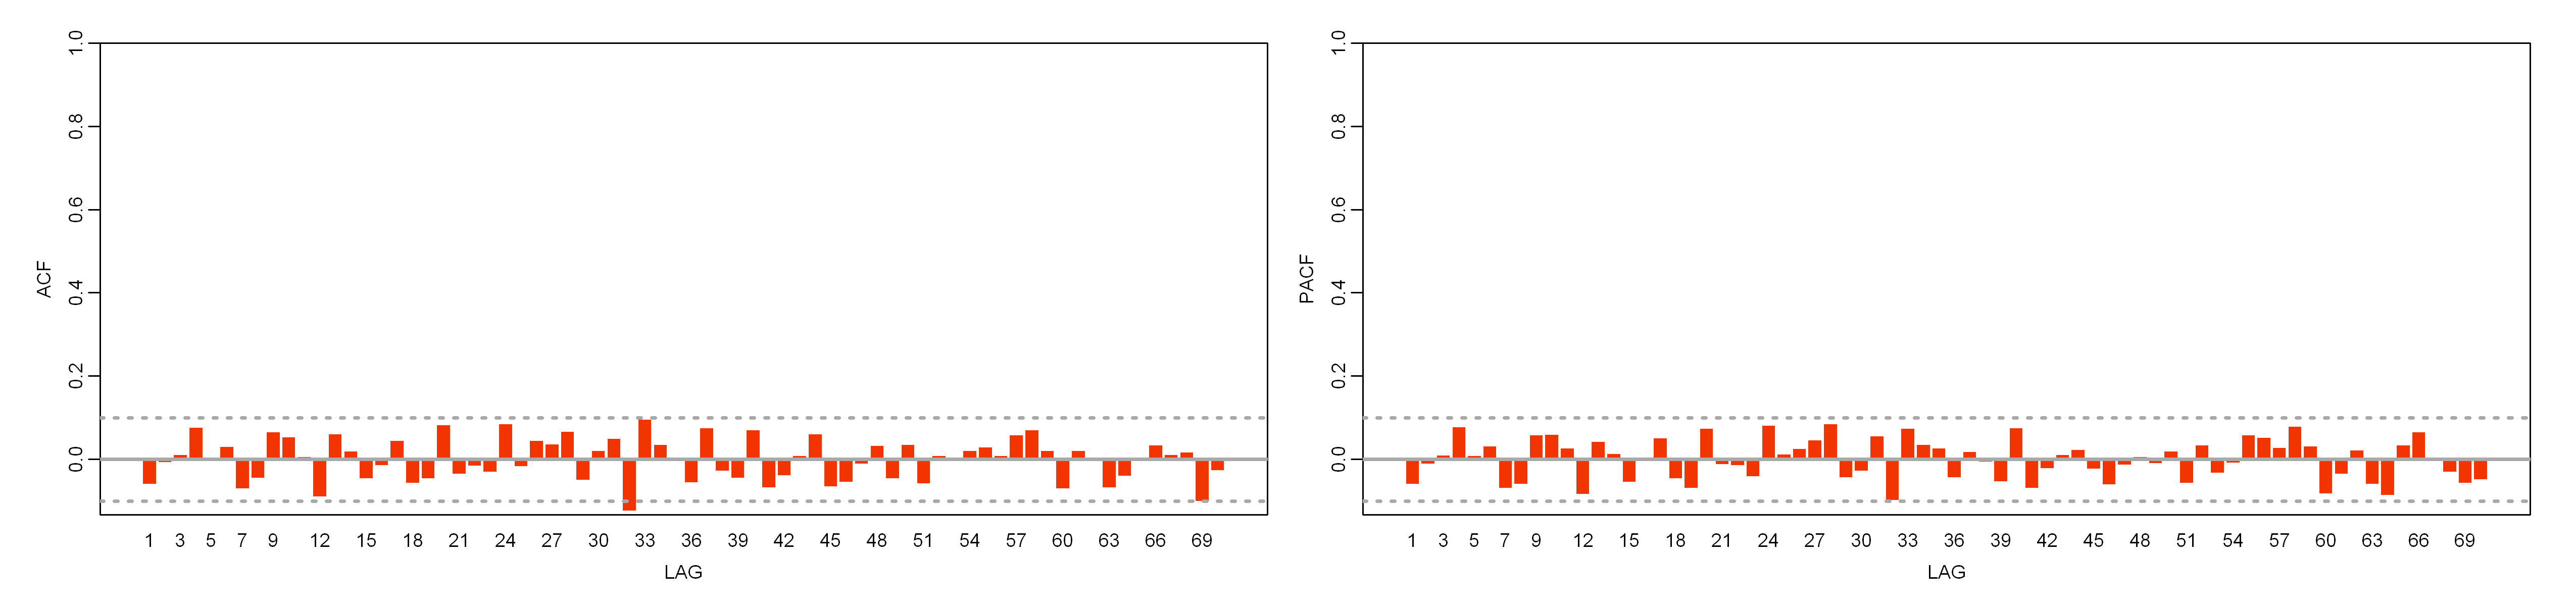

In [38]:
fig(17, 4, 300)
ac(BTC_daily_logret, max.lag=70)

A series of log-returns behaves like "white noise". On such a series we can't build the ARIMA model.

Let’s get the first differences of log-returns series

In [39]:
BTC_daily_logretdiff <- diff(log(BTC_daily$CBBTCUSD), differences=2)

The first differences of log-returns plot

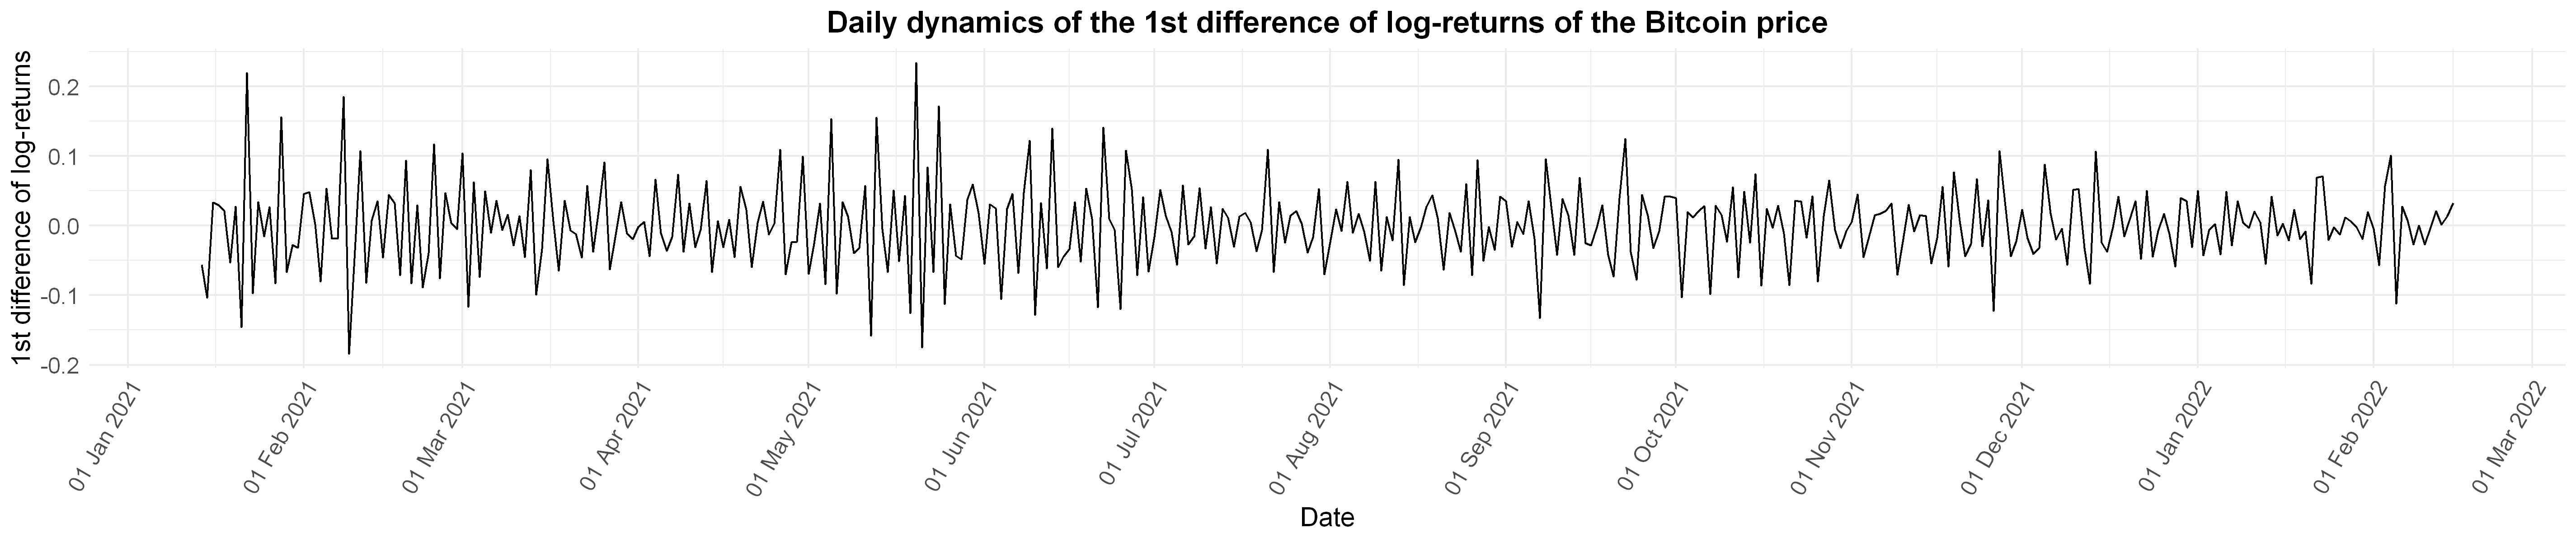

In [40]:
fig(19, 4, 300)
ggplot(BTC_daily[-c(1, 2), ], aes(DATE, BTC_daily_logretdiff)) +
    geom_line() +
    xlab('Date') +
    ylab('1st difference of log-returns') +
    ggtitle('Daily dynamics of the 1st difference of log-returns of the Bitcoin price') +
    scale_x_date(date_breaks='1 month',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2021-01-14'), as.Date('2022-02-15'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(angle=60, hjust=1, size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14))

There is the effect of volatility clustering in the first part of the series. Therefore, this series is likely to be non-stationary in terms of variance.

Let's get descriptive statistics of the series

In [41]:
stats_BTC_daily_logretdiff <- describe(BTC_daily_logretdiff)
print(stats_BTC_daily_logretdiff)

   vars   n mean   sd median trimmed  mad   min  max range skew kurtosis se
X1    1 398    0 0.06      0       0 0.05 -0.18 0.23  0.42 0.28     1.21  0


Kurtosis exceed the possible limits [-1; 1], but not critically. The distribution is slightly right-skewed.

Distribution plot of the first differences of the log-returns

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



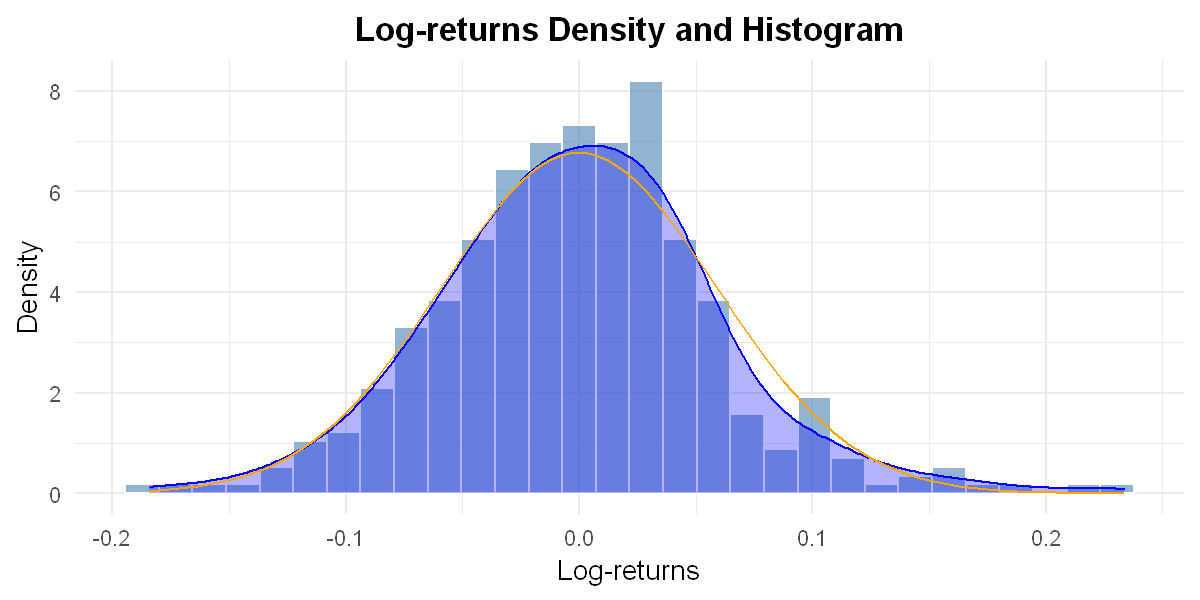

In [42]:
fig(6, 3, 200)
ggplot(BTC_daily[-c(1, 2), ], aes(BTC_daily_logretdiff)) +
    geom_histogram(aes(y=..density..), position='identity', fill='steelblue', col='white', alpha=.6) +
    geom_density(fill='blue', col='blue', alpha=.3, adjust=1.45) +
    stat_function(fun=dnorm, args=list(mean=stats_BTC_daily_logretdiff$mean, sd=stats_BTC_daily_logretdiff$sd), col='orange') +
    xlab('Log-returns') +
    ylab('Density') +
    ggtitle('Log-returns Density and Histogram') +
    theme_minimal() +
    theme(plot.title=element_text(hjust=.5, size=12, face='bold'),
          axis.title=element_text(size=10),
          axis.text.x=element_text(size=8),
          axis.text.y=element_text(size=8))

[1] 127   9

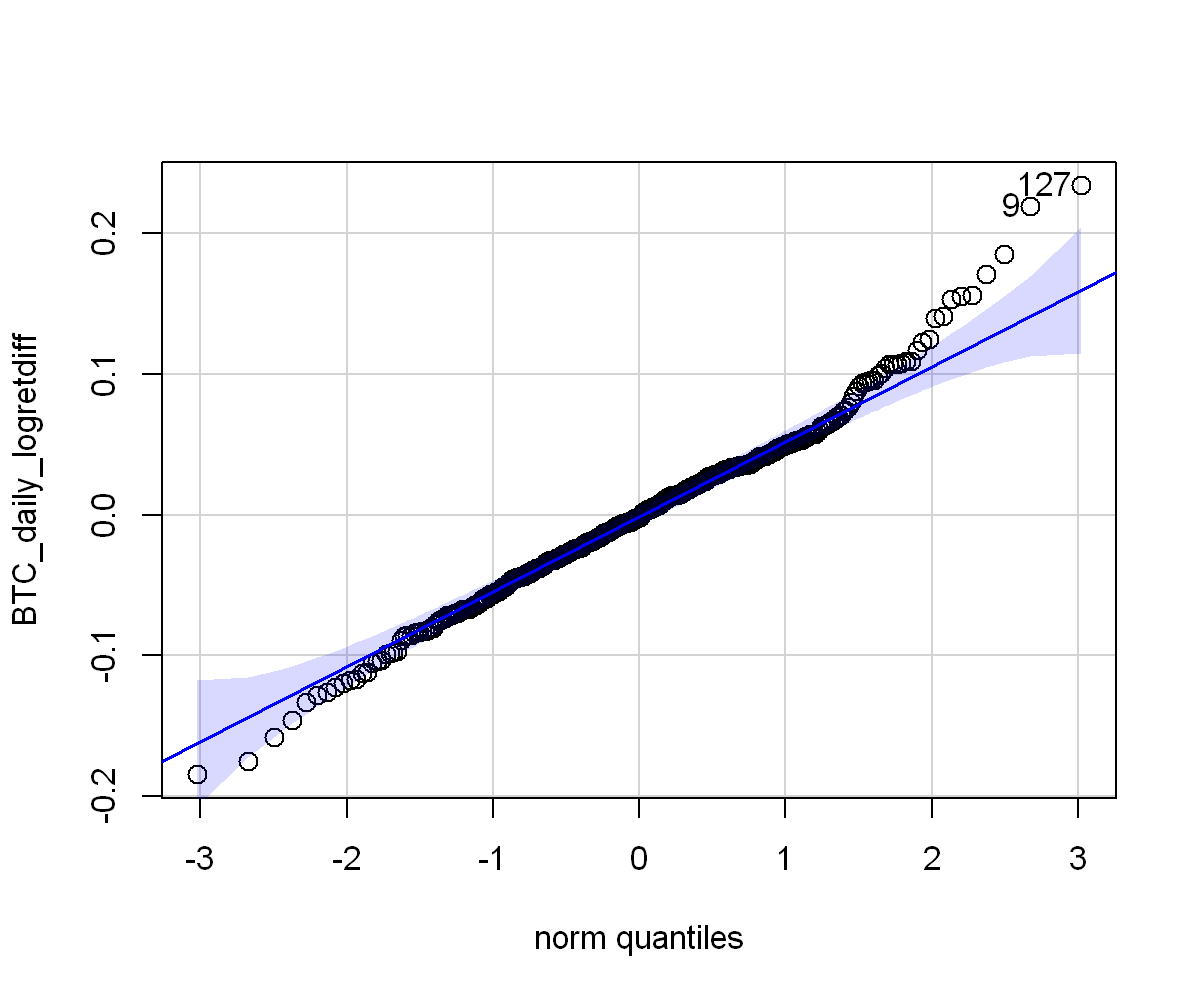

In [43]:
fig(6, 5, 200)
car::qqPlot(BTC_daily_logretdiff,
            cex=1.3, lwd=1.8,
            envelope=list(border=FALSE))

In general, the distribution of the series is close to normal.

Let’s test the series for stationarity by applying parametric tests

#### 1. Constant variance

##### Fisher's test

In [44]:
var.test(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398], alternative='two.sided')


	F test to compare two variances

data:  BTC_daily_logretdiff[1:199] and BTC_daily_logretdiff[200:398]
F = 2.2763, num df = 198, denom df = 198, p-value = 1.189e-08
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.721432 3.009935
sample estimates:
ratio of variances 
          2.276268 


##### Bartlett's test

In [45]:
bartlett.test(list(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398]))


	Bartlett test of homogeneity of variances

data:  list(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398])
Bartlett's K-squared = 32.504, df = 1, p-value = 1.189e-08


##### Cochran's test

In [46]:
library(outliers)


Attaching package: 'outliers'


The following object is masked from 'package:psych':

    outlier




In [47]:
# divide the series into 3 parts and calculate their variances
cochran.test(object=c(var(BTC_daily_logretdiff[1:133]),
                      var(BTC_daily_logretdiff[134:266]),
                      var(BTC_daily_logretdiff[267:398])),
             data=c(133, 133, 132))


	Cochran test for outlying variance

data:  c(var(BTC_daily_logretdiff[1:133]), var(BTC_daily_logretdiff[134:266]),     var(BTC_daily_logretdiff[267:398]))
C = 0.52875, df = 132.67, k = 3.00, p-value = 4.502e-08
alternative hypothesis: Group 1 has outlying variance
sample estimates:
          1           2           3 
0.005521120 0.002948728 0.001972026 


According to the results of all three tests, we reject the null hypothesis about the constant variance of the time series.

#### 2. Constant mean

##### Student's t-test

In [48]:
t.test(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398], alternative='two.sided', var.equal=FALSE)


	Welch Two Sample t-test

data:  BTC_daily_logretdiff[1:199] and BTC_daily_logretdiff[200:398]
t = -0.15076, df = 343.82, p-value = 0.8803
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01251578  0.01073369
sample estimates:
    mean of x     mean of y 
-0.0005858787  0.0003051685 


##### Fisher's test

In [49]:
var1 <- var(BTC_daily_logretdiff[1:133])
var2 <- var(BTC_daily_logretdiff[134:266])
var3 <- var(BTC_daily_logretdiff[267:398])
var_mean <- sum(c(var1 * (133 - 1), var2 * (133 - 1), var3 * (132 - 1))) / (398 - 3)  # average variance of the time series in case of not constant variance
mean1 <- mean(BTC_daily_logretdiff[1:133])
mean2 <- mean(BTC_daily_logretdiff[134:266])
mean3 <- mean(BTC_daily_logretdiff[267:398])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(BTC_daily_logretdiff)) ^ 2) * c(133, 133, 132)) / ((3 - 1) * var_mean)  # calculated statistic
F.crit <- qf(0.975, 3 - 1, 398 - 3)  # critical value
print(F.stat)
print(F.crit)

[1] 0.008982711
[1] 3.723545


The results of both tests allow us to accept the mathematical expectation constancy hypothesis.

#### 3. Uncorrelated series levels

In [50]:
logretdiff_acf <- acf(BTC_daily_logretdiff, lag.max=12, pl=FALSE)
logretdiff_acf


Autocorrelations of series 'BTC_daily_logretdiff', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.524  0.025 -0.025  0.066 -0.053  0.065 -0.061 -0.030  0.042  0.024 
    11     12 
 0.017 -0.112 

In [51]:
pacf(BTC_daily_logretdiff, lag.max=12, pl=FALSE)


Partial autocorrelations of series 'BTC_daily_logretdiff', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.524 -0.345 -0.295 -0.163 -0.154 -0.039 -0.054 -0.137 -0.119 -0.064  0.034 
    12 
-0.097 

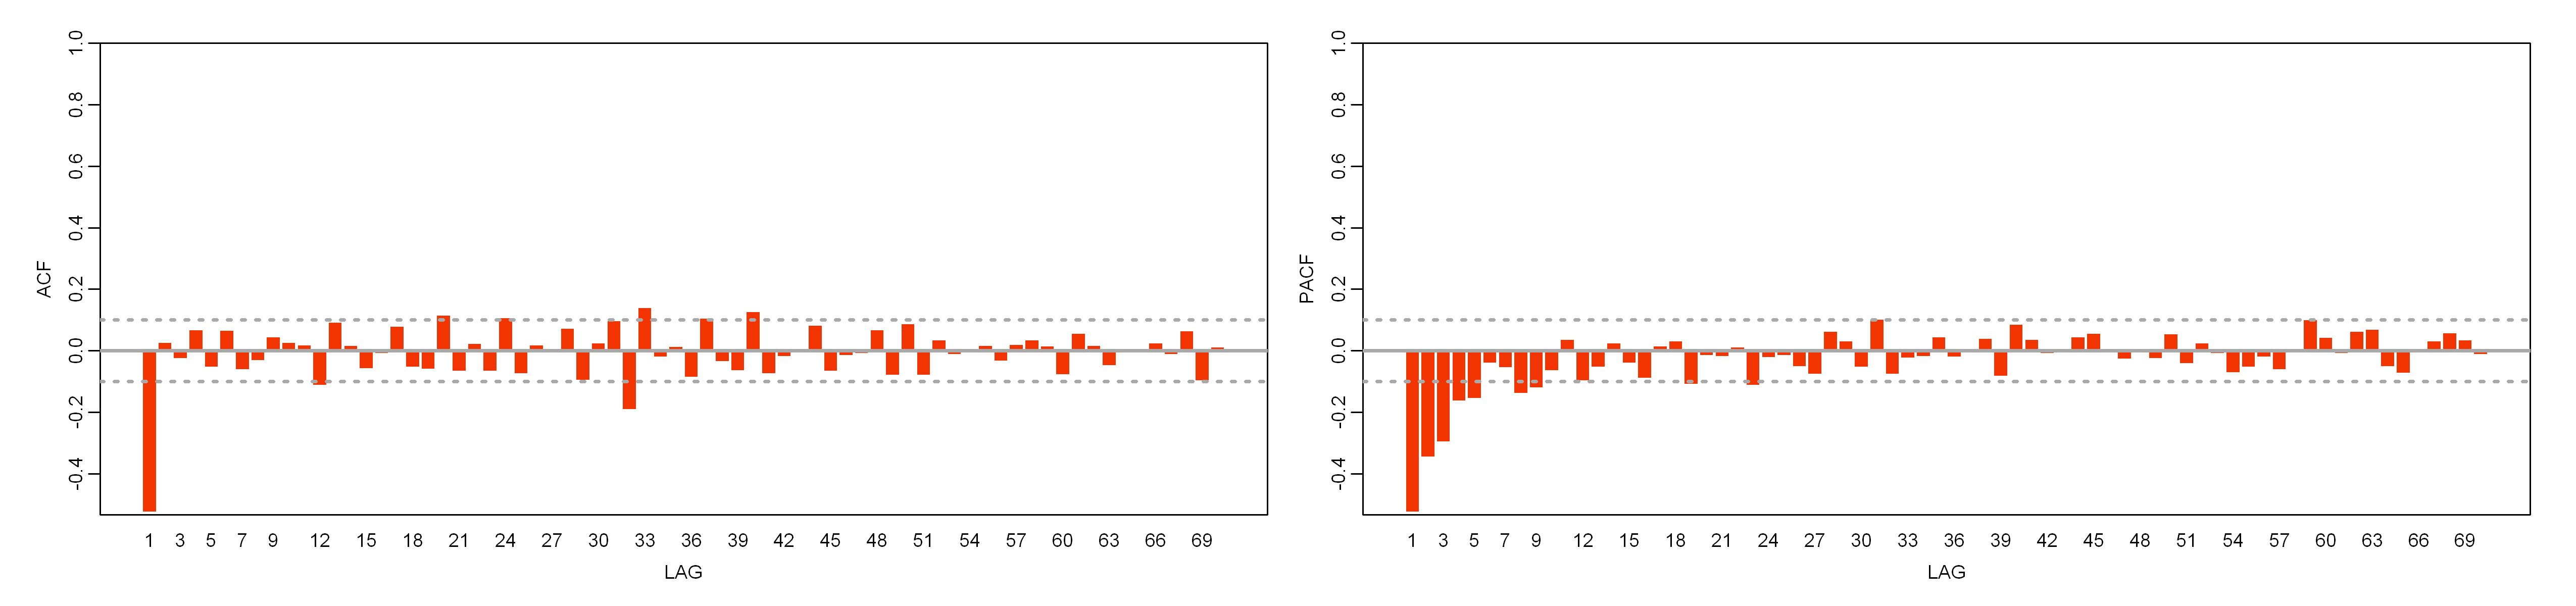

In [52]:
fig(17, 4, 300)
ac(BTC_daily_logretdiff, max.lag=70)

There are general patterns of the correlograms of the MA(1) process on ACF and PACF of the first differences of log-returns series. However, the value of the sampled autocorrelation coefficient for the first lag is less than -0.5, hence the series is overdifferenced. So the MA(1) model can't be built because of the condition imposed on the first order autocorrelation coefficient. We can try to build the 3rd order autoregressive model (or up to 5th order, but it will be difficult to estimate quality  and to undifference the higher order model to get the forecast) on this series. On the errors of this model we will build the model of the ARCH/GARCH family.

### Building ARIMA(p, d, q)-GARCH(h, l) models

AR(3) model on the first differences of log-returns series

In [53]:
logretdiff_arima <- Arima(BTC_daily_logretdiff, order=c(3, 0, 0), include.constant=TRUE)
summary(logretdiff_arima)

Series: BTC_daily_logretdiff 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
          ar1      ar2      ar3   mean
      -0.8258  -0.5825  -0.3131  0e+00
s.e.   0.0481   0.0568   0.0481  8e-04

sigma^2 = 0.002:  log likelihood = 673.5
AIC=-1337   AICc=-1336.84   BIC=-1317.06

Training set error measures:
                        ME       RMSE        MAE     MPE     MAPE      MASE
Training set -0.0002665231 0.04449914 0.03413949 55.2257 169.2423 0.4366565
                    ACF1
Training set -0.04827474

Confidence intervals for model coefficient estimates

In [54]:
print(logretdiff_arima$coef)

          ar1           ar2           ar3     intercept 
-8.258081e-01 -5.825110e-01 -3.131080e-01 -3.834895e-05 


In [55]:
print(confint(logretdiff_arima))

                 2.5 %       97.5 %
ar1       -0.919993398 -0.731622754
ar2       -0.693922283 -0.471099813
ar3       -0.407335223 -0.218880724
intercept -0.001652163  0.001575465


The coefficient estimates are statistically significant because the confidence intervals have not crossed the 0 value.

The resulting model is: $Δz_t = -0.00004 - 0.8258 \cdot Δz_{t-1} - 0.5825 \cdot Δz_{t-2} - 0.3131 \cdot Δz_{t-3}$,  
где $Δz_t = z_t - z_{t-1}$,  
$z_t = \ln(\frac{y_t} {y_{t-1}}) = \ln(y_t) - \ln(y_{t-1})$.

Let's check all necessary properties and constraints of model coefficients and process characteristics

1. Stationarity:

Let's plot the inverse roots of characteristic equation of this process

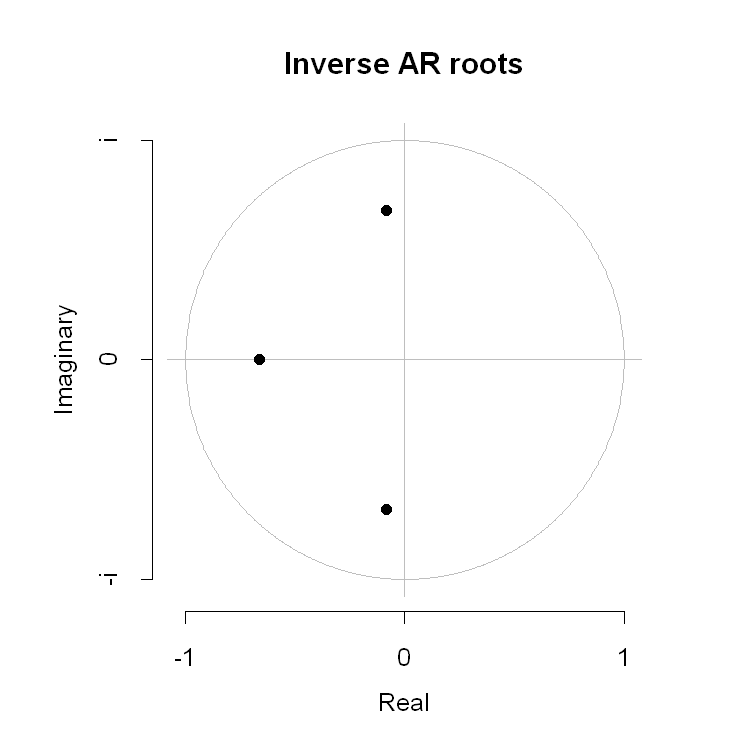

In [56]:
fig(5, 5, 150)
plot(logretdiff_arima)

The roots of the characteristic equation are outside of the unit circle. So the process is stationary and invertible.

2. $M[y_t] = \frac{α_0} {1 - α_1 - α_2 - α_3}$

In [57]:
a_0 <- logretdiff_arima$coef[[4]]
a_1 <- logretdiff_arima$coef[[1]]
a_2 <- logretdiff_arima$coef[[2]]
a_3 <- logretdiff_arima$coef[[3]]

In [58]:
print(mean(BTC_daily_logretdiff))
print(format(a_0 / (1 - a_1 - a_2 - a_3), scientific=FALSE))

[1] -0.0001403551
[1] "-0.00001409148"


Values are statistically equal.

3. $D[y_t] = \frac{σ^2_e} {1 - α_1ρ_1 - α_2ρ_2 - α_3ρ_3}$:

In [59]:
rho_1 <- logretdiff_acf$acf[2]
rho_2 <- logretdiff_acf$acf[3]
rho_3 <- logretdiff_acf$acf[4]

In [60]:
print(var(BTC_daily_logretdiff)[[1]][1])
print(logretdiff_arima$sigma2)

[1] 0.003467047
[1] 0.002000277


Values are statistically equal.

The model satisfies all conditions.

Let’s analyse the properties of a series of model errors to be close to "white noise" characteristics

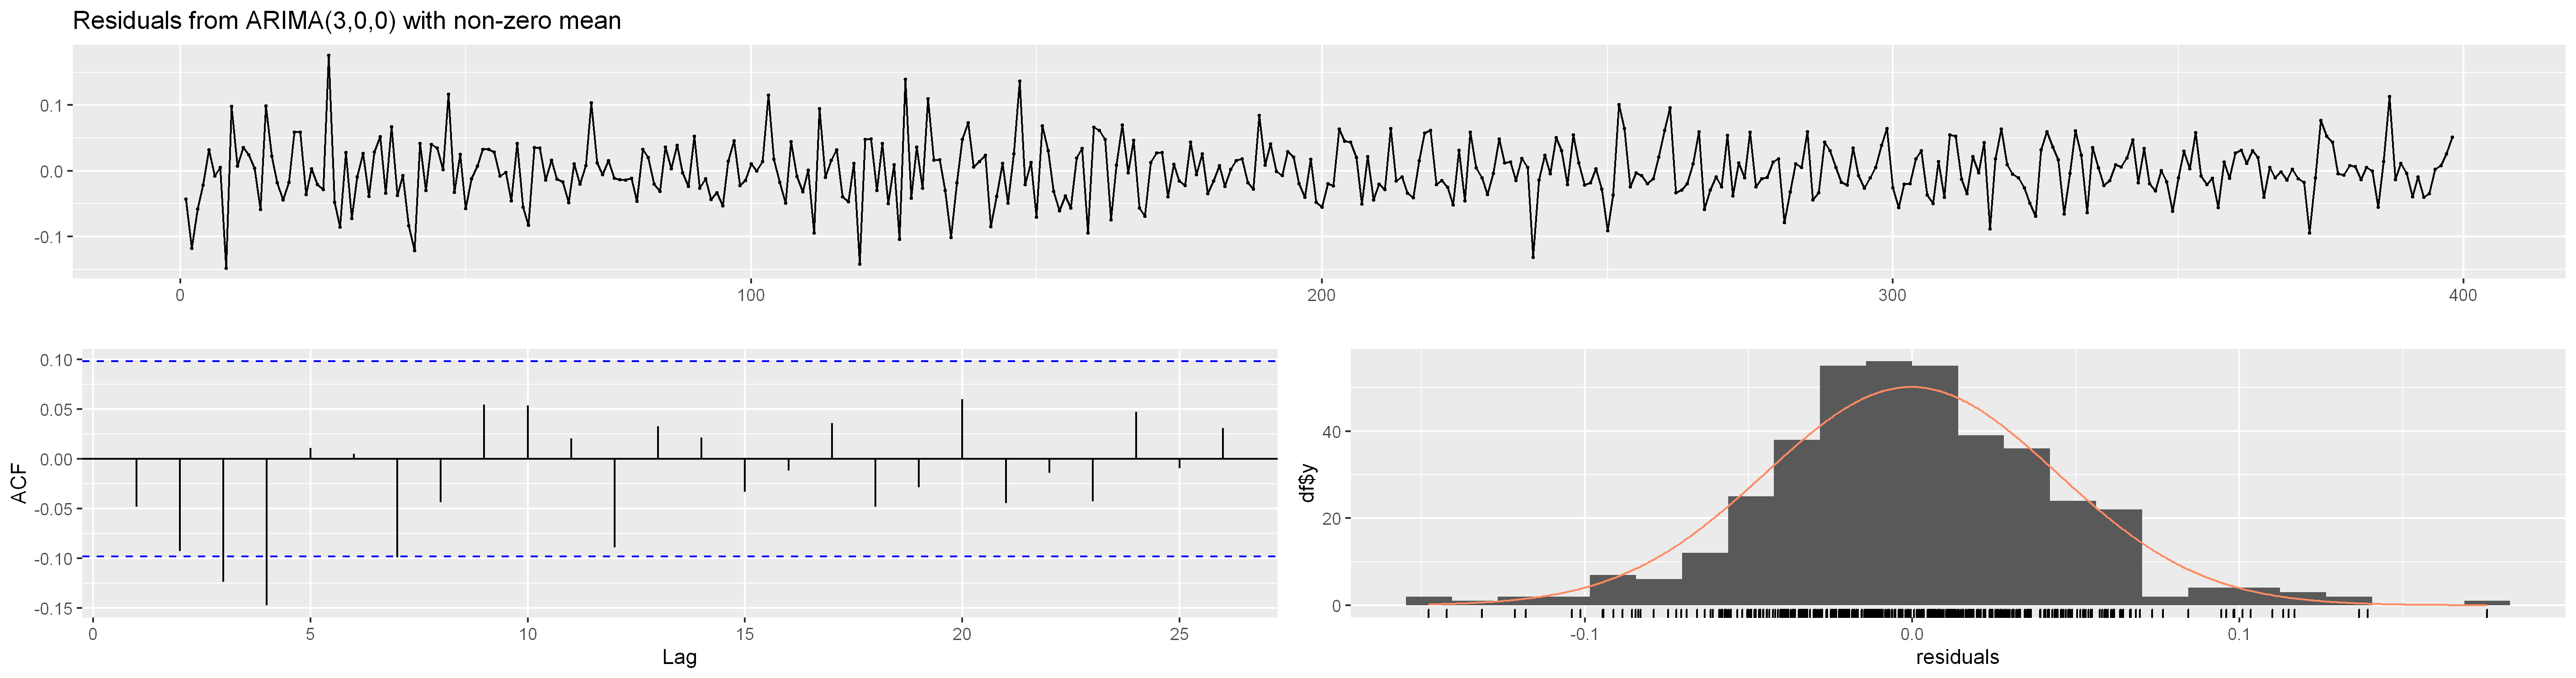

In [61]:
fig(19, 5, 300)
checkresiduals(logretdiff_arima, test=FALSE)

Descriptive statistics for the series of model errors

In [62]:
print(describe(logretdiff_arima$residuals))

   vars   n mean   sd median trimmed  mad   min  max range skew kurtosis se
X1    1 398    0 0.04      0       0 0.04 -0.15 0.18  0.32 0.12     1.14  0


The skew and kurtosis values lie within the possible range of deviations [-1; 1]. The distribution of residuals is close to normal. Therefore, we use parametric tests to check the constancy of the mathematical expectation and the variance of residuals.

#### 1. Constant variance

##### Fisher's test

In [63]:
var.test(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398], alternative='two.sided')


	F test to compare two variances

data:  logretdiff_arima$residuals[1:199] and logretdiff_arima$residuals[200:398]
F = 1.7194, num df = 198, denom df = 198, p-value = 0.0001534
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.300316 2.273611
sample estimates:
ratio of variances 
          1.719422 


In [64]:
var(logretdiff_arima$residuals[1:199])  # variance of the 1st part of the residuals series

[1] 0.00251631

In [65]:
var(logretdiff_arima$residuals[200:398])  # variance of the 2nd part of the residuals series

[1] 0.001463463

##### Bartlett's test

In [66]:
bartlett.test(list(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398]))


	Bartlett test of homogeneity of variances

data:  list(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398])
Bartlett's K-squared = 14.33, df = 1, p-value = 0.0001534


##### Cochran's test

In [67]:
var1 <- var(logretdiff_arima$residuals[1:133])
var2 <- var(logretdiff_arima$residuals[134:266])
var3 <- var(logretdiff_arima$residuals[267:398])
outliers::cochran.test(object=c(var1, var2, var3), data=c(133, 133, 132))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.45663, df = 132.67, k = 3.00, p-value = 0.0006113
alternative hypothesis: Group 1 has outlying variance
sample estimates:
          1           2           3 
0.002730081 0.001952057 0.001296617 


According to the results of three tests we reject the null hypothesis of constancy of variance of the time series.

#### 2. Zero-equal mean

##### Student's t-test

In [68]:
t.test(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398], alternative='two.sided', var.equal=FALSE)


	Welch Two Sample t-test

data:  logretdiff_arima$residuals[1:199] and logretdiff_arima$residuals[200:398]
t = -0.20754, df = 370.1, p-value = 0.8357
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.009721834  0.007865632
sample estimates:
    mean of x     mean of y 
-0.0007305737  0.0001975274 


##### Fisher's test

In [69]:
var1 <- var(logretdiff_arima$residuals[1:133])
var2 <- var(logretdiff_arima$residuals[134:266])
var3 <- var(logretdiff_arima$residuals[267:398])
var_mean <- sum(c(var1 * (133 - 1), var2 * (133 - 1), var3 * (132 - 1))) / (398 - 3)
mean1 <- mean(logretdiff_arima$residuals[1:133])
mean2 <- mean(logretdiff_arima$residuals[134:266])
mean3 <- mean(logretdiff_arima$residuals[267:398])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(logretdiff_arima$residuals)) ^ 2) * c(133, 133, 132)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 398 - 3)
print(F.stat)
print(F.crit)

[1] 0.04551615
[1] 3.723545


The results of both tests allow us to accept the mathematical expectation zero-equality hypothesis.

In [70]:
mean(logretdiff_arima$residuals)

[1] -0.0002665231

#### 3. Uncorrelated residuals

To check the significance of several correlation coefficients at once, we use the Ljung-Box and Box-Pierce tests for the first 15 lags.

##### Ljung-Box test

In [71]:
Box.test(logretdiff_arima$residuals, lag=15, type='Ljung')


	Box-Ljung test

data:  logretdiff_arima$residuals
X-squared = 31.073, df = 15, p-value = 0.008589


##### Box-Pierce test

In [72]:
Box.test(logretdiff_arima$residuals, lag=15, type='Box-Pierce')


	Box-Pierce test

data:  logretdiff_arima$residuals
X-squared = 30.48, df = 15, p-value = 0.0103


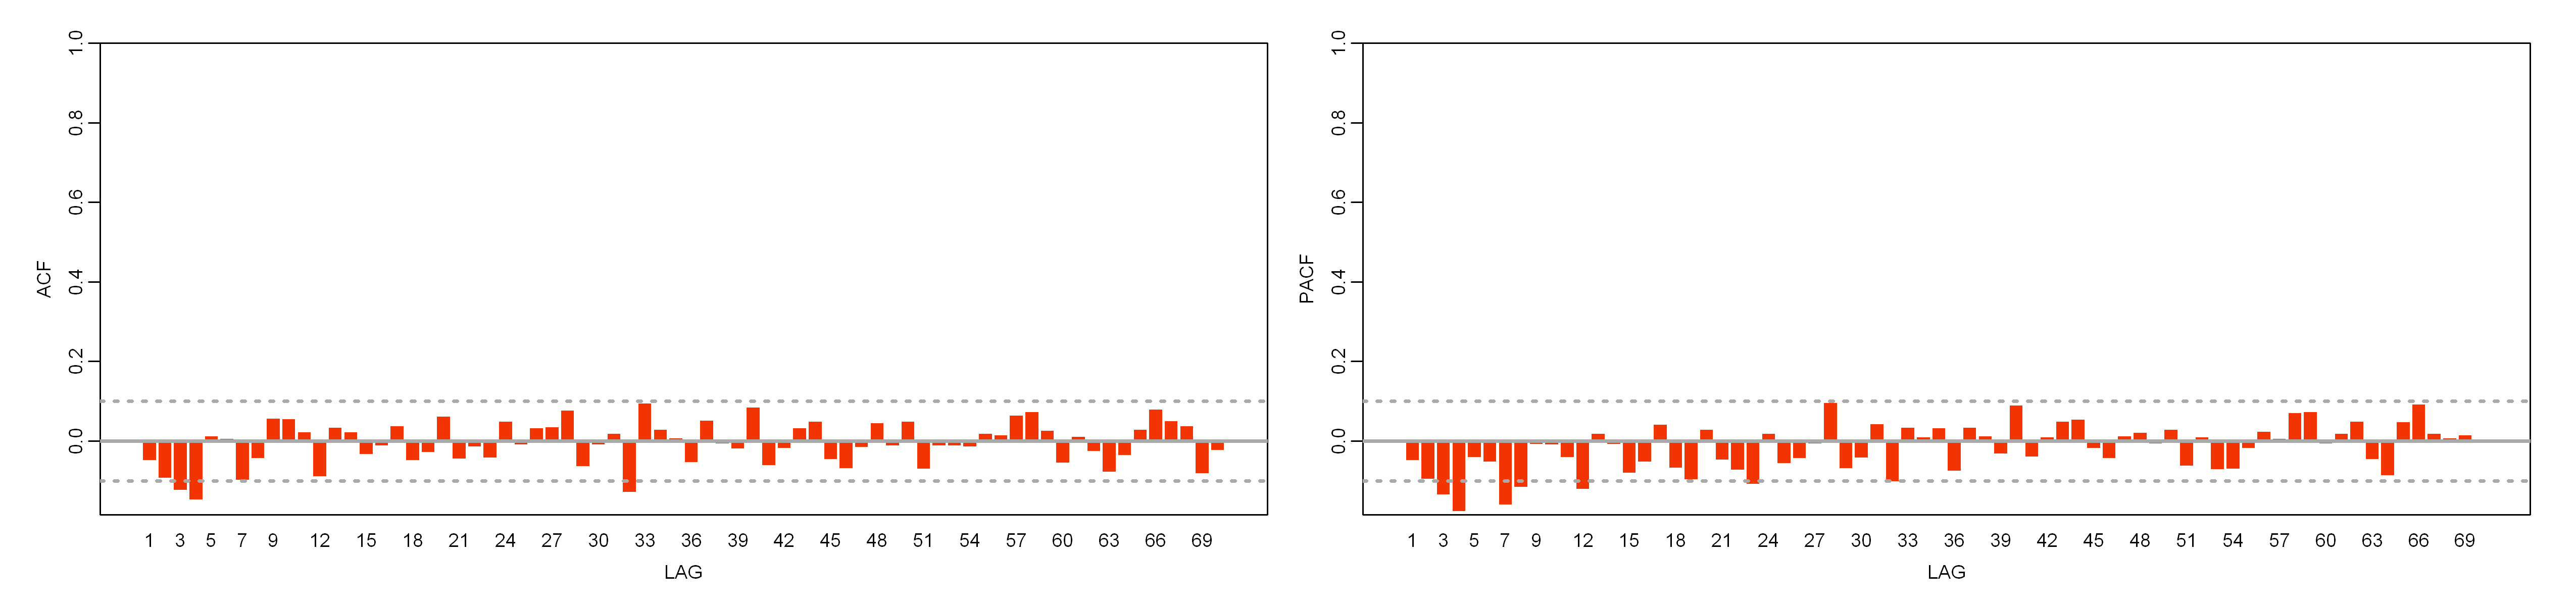

In [73]:
fig(17, 4, 300)
ac(logretdiff_arima$residuals, max.lag=70)

We reject the hypothesis that there is no autocorrelation in residuals.

Despite the violation of the restrictions, we can say that the AR(3) model can be used for forecasting, since the models of the AR(p) family do not have rigorous restrictions on stationarity. But because there is an autocorrelation in the residuals series, then the series of model residuals must be modelled with the autoregressive conditional heteroskedasticity model ARCH(h) or GARCH(h, l).

To confirm the presence of ARCH-effects, we will use the Ljung-Box and Box-Pierce tests for a series of squared residuals, since the squares of residuals are similar to the variance

##### Ljung-Box test

In [74]:
Box.test(logretdiff_arima$residuals ^ 2, lag=15, type='Ljung')


	Box-Ljung test

data:  logretdiff_arima$residuals^2
X-squared = 30.689, df = 15, p-value = 0.009665


##### Box-Pierce test

In [75]:
Box.test(logretdiff_arima$residuals ^ 2, lag=15, type='Box-Pierce')


	Box-Pierce test

data:  logretdiff_arima$residuals^2
X-squared = 29.79, df = 15, p-value = 0.0127


Both criteria confirm the presence of autocorrelation in the squared residuals series.

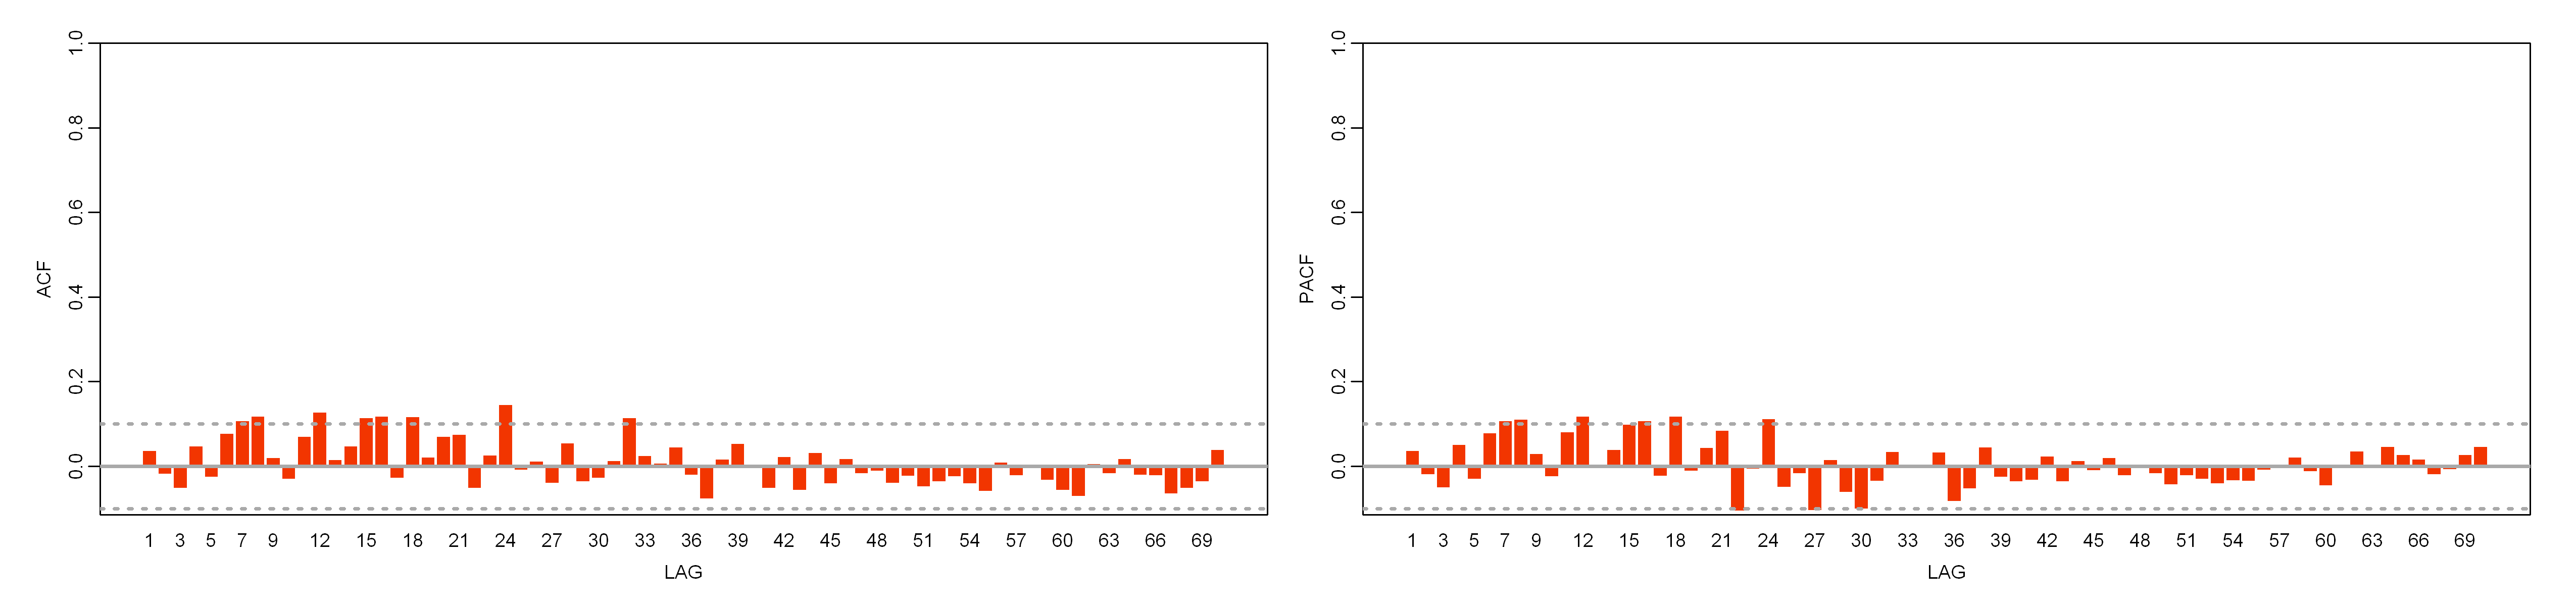

In [76]:
fig(17, 4, 300)
ac(logretdiff_arima$residuals ^ 2, max.lag=70)

Some coefficients goes beyond the border of 95% confidence interval, that is, the condition is met:  
$∃cov(e_t^2,e_{t-τ}^2) ≠ 0$ for some τ ≥ 1.

ACF and PACF do not show similarities with theoretical ones for ARIMA models, but the residuals series shows that GARCH(1, 1) is likely to be suitable for volatility modelling.  
Let’s build ARCH(1) and GARCH(1, 1) models on the ARIMA model residuals and compare their characteristics.

In [77]:
library(fGarch)

Loading required package: timeDate

Loading required package: timeSeries


Attaching package: 'timeSeries'


The following object is masked from 'package:outliers':

    outlier


The following object is masked from 'package:psych':

    outlier


Loading required package: fBasics


Attaching package: 'fBasics'


The following object is masked from 'package:psych':

    tr




ARCH(1) model

In [78]:
logretdiff_arch <- garchFit(~garch(1, 0), logretdiff_arima$residuals, trace=FALSE, include.mean=FALSE)
summary(logretdiff_arch)

Warning message:
"Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead."



Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(1, 0), data = logretdiff_arima$residuals, 
    include.mean = FALSE, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 0)
<environment: 0x0000000037205470>
 [data = logretdiff_arima$residuals]

Conditional Distribution:
 norm 

Coefficient(s):
    omega     alpha1  
0.0019193  0.0305501  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  0.0019193   0.0001575   12.186   <2e-16 ***
alpha1 0.0305501   0.0436881    0.699    0.484    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 674.257    normalized:  1.694113 

Description:
 Mon Jul 18 16:31:33 2022 by user: goroh 


Standardised Residuals Tests:
                                Statistic p-Value    
 Jarque-Bera Test   R    Chi^2  23.77582  6.87299e-06
 Shapiro-Wilk Test  R    W      0.987399  0.001597272
 Ljung-Box Test     R    Q(10)  26.8878   0.002712912
 Ljung-Box T

The estimation of $α_1$ coefficient of this model is not statistically significant according to the Student's t-statistic, so this model will not be considered further.  
Moving on to the GARCH(1, 1) model

In [79]:
logretdiff_garch <- garchFit(~garch(1, 1), logretdiff_arima$residuals, trace=FALSE, include.mean=FALSE)
summary(logretdiff_garch)

Warning message:
"Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead."



Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(1, 1), data = logretdiff_arima$residuals, 
    include.mean = FALSE, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x0000000037ebfdf0>
 [data = logretdiff_arima$residuals]

Conditional Distribution:
 norm 

Coefficient(s):
     omega      alpha1       beta1  
5.6136e-05  2.8271e-02  9.4097e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  5.614e-05   3.827e-05    1.467   0.1424    
alpha1 2.827e-02   1.384e-02    2.042   0.0411 *  
beta1  9.410e-01   2.706e-02   34.771   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 678.8246    normalized:  1.705589 

Description:
 Mon Jul 18 16:31:33 2022 by user: goroh 


Standardised Residuals Tests:
                                Statistic p-Value     
 Jarque-Bera Test   R    Chi^2  19.61656  5.499437e-05
 Shapiro-Wilk Test  R    W      0.9881

In [80]:
print(logretdiff_garch@fit$coef)

       omega       alpha1        beta1 
5.613647e-05 2.827052e-02 9.409746e-01 


In [81]:
garch_alpha1 <- logretdiff_garch@fit$coef[[2]]
garch_beta1 <- logretdiff_garch@fit$coef[[3]]

garch_alpha1 + garch_beta1  # stationarity constraint

[1] 0.9692451

The model is: $σ ̂_t^2  = 0,00006 + 0,0283 \cdot ε_{t-1}^2 + 0,941 \cdot σ_{t-1}^2$.

All coefficients of this model are statistically significant and satisfy the conditions:  
$0 < ω ̂ < 1, 0 ≤ α ̂_1 < 1, 0 ≤ β ̂_1 < 1, α ̂_1 + β ̂_1 < 1$.

Let’s also build the eGARCH(1, 1) model

In [82]:
library(rugarch)

Loading required package: parallel


Attaching package: 'rugarch'


The following objects are masked from 'package:fBasics':

    qgh, qnig


The following object is masked from 'package:purrr':

    reduce


The following object is masked from 'package:stats':

    sigma




In [83]:
logretdiff_egarch <- ugarchfit(
    spec=ugarchspec(mean.model=list(armaOrder=c(0, 0), include.mean=FALSE),
                    variance.model=list(model='eGARCH', garchOrder=c(1, 1)),
                    distribution.model='norm'), 
    data=logretdiff_arima$residuals,
    numderiv.control=list(grad.eps=1e-9, hess.eps=1e-9))
logretdiff_egarch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega  -0.074296     1.7e-05  -4372.1        0
alpha1 -0.171918     2.3e-05  -7399.4        0
beta1   0.989712     5.4e-05  18445.1        0
gamma1 -0.092798     1.6e-05  -5871.8        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega  -0.074296    0.070572 -1.05276 0.292451
alpha1 -0.171918    0.191081 -0.89971 0.368272
beta1   0.989712    0.265011  3.73461 0.000188
gamma1 -0.092798    0.186688 -0.49708 0.619135

LogLikelihood : 696.4307 

Information Criteria
------------------------------------
                    
Akaike       -3.4796
Bayes        -3.4395
Shibata      -3.4798
Hannan-Quinn -3.4637

Weig

In [84]:
print(logretdiff_egarch@fit$coef)

      omega      alpha1       beta1      gamma1 
-0.07429553 -0.17191825  0.98971167 -0.09279808 


In [85]:
egarch_stdresid_cdf <- ecdf(logretdiff_arima$residuals / logretdiff_egarch@fit$sigma)  # standardized residuals CDF
prob <- 1 - egarch_stdresid_cdf(0)  # P(z_t > 0) = 1 - P(z_t <= 0)
prob

[1] 0.4824121

In [86]:
egarch_alpha1 <- logretdiff_egarch@fit$coef[[2]]
egarch_beta1 <- logretdiff_egarch@fit$coef[[3]]
egarch_gamma1 <- logretdiff_egarch@fit$coef[[4]]

abs(egarch_alpha1 + egarch_beta1) ^ prob * abs(egarch_alpha1 + egarch_beta1 + egarch_gamma1) ^ (1 - prob)  # stationarity constraint

[1] 0.7683683

The model is: $lnσ ̂_t^2=-0,074+0,99\cdot lnσ_{t-1}^2-0,172\cdot |z_{t-1}|-0,093\cdot z_{t-1}$.
All coefficients of this model are statistically significant and satisfy the conditions:  
$|ω ̂, α ̂_1, β ̂_1, γ ̂_1| < 1, |α ̂_1 + β ̂_1|^{P(z_t > 0)}\cdot|α ̂_1 + β ̂_1 + γ ̂_1|^{1-P(z_t > 0)} < 1$.  
But the $β_1$ parameter estimate is very close to 1, and robust standard errors give us insignificant model parameter estimates.

Let’s also build the tGARCH(1, 1) model

In [87]:
logretdiff_tgarch <- ugarchfit(
    spec=ugarchspec(mean.model=list(armaOrder=c(0, 0), include.mean=FALSE),
                    variance.model=list(model='fGARCH', garchOrder=c(1, 1), submodel='TGARCH'),
                    distribution.model='norm'), 
    data=logretdiff_arima$residuals,
    numderiv.control=list(grad.eps=1e-9, hess.eps=1e-9))
logretdiff_tgarch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: fGARCH(1,1)
fGARCH Sub-Model	: TGARCH
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.001949    0.001206   1.6161 0.106075
alpha1  0.060447    0.017530   3.4482 0.000564
beta1   0.907861    0.033283  27.2771 0.000000
eta11   1.000000    0.445989   2.2422 0.024948

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.001949    0.000928   2.1007 0.035670
alpha1  0.060447    0.015360   3.9355 0.000083
beta1   0.907861    0.022888  39.6650 0.000000
eta11   1.000000    0.447319   2.2355 0.025382

LogLikelihood : 680.3061 

Information Criteria
------------------------------------
                    
Akaike       -3.3985
Bayes        -3.3585
Shibata      -3.3987


In [88]:
print(logretdiff_tgarch@fit$coef)

      omega      alpha1       beta1       eta11 
0.001948896 0.060447402 0.907861004 0.999999906 


The model is: $σ ̂_t^2=0,002+0,908\cdot σ_{t-1}^2+0,06\cdot ε_{t-1}^2+0,99999991\cdot ε_{t-1}^2d_{t-1}$.

All coefficients of this model are statistically significant and satisfy the conditions:  
$ω ̂ > 0, α ̂_1 > 0, β ̂_1 > 0, ŋ ̂ > 0$.

The tGACRH(1, 1) model fits the data best.

Conditional variance predicted using tGARCH(1, 1) model

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



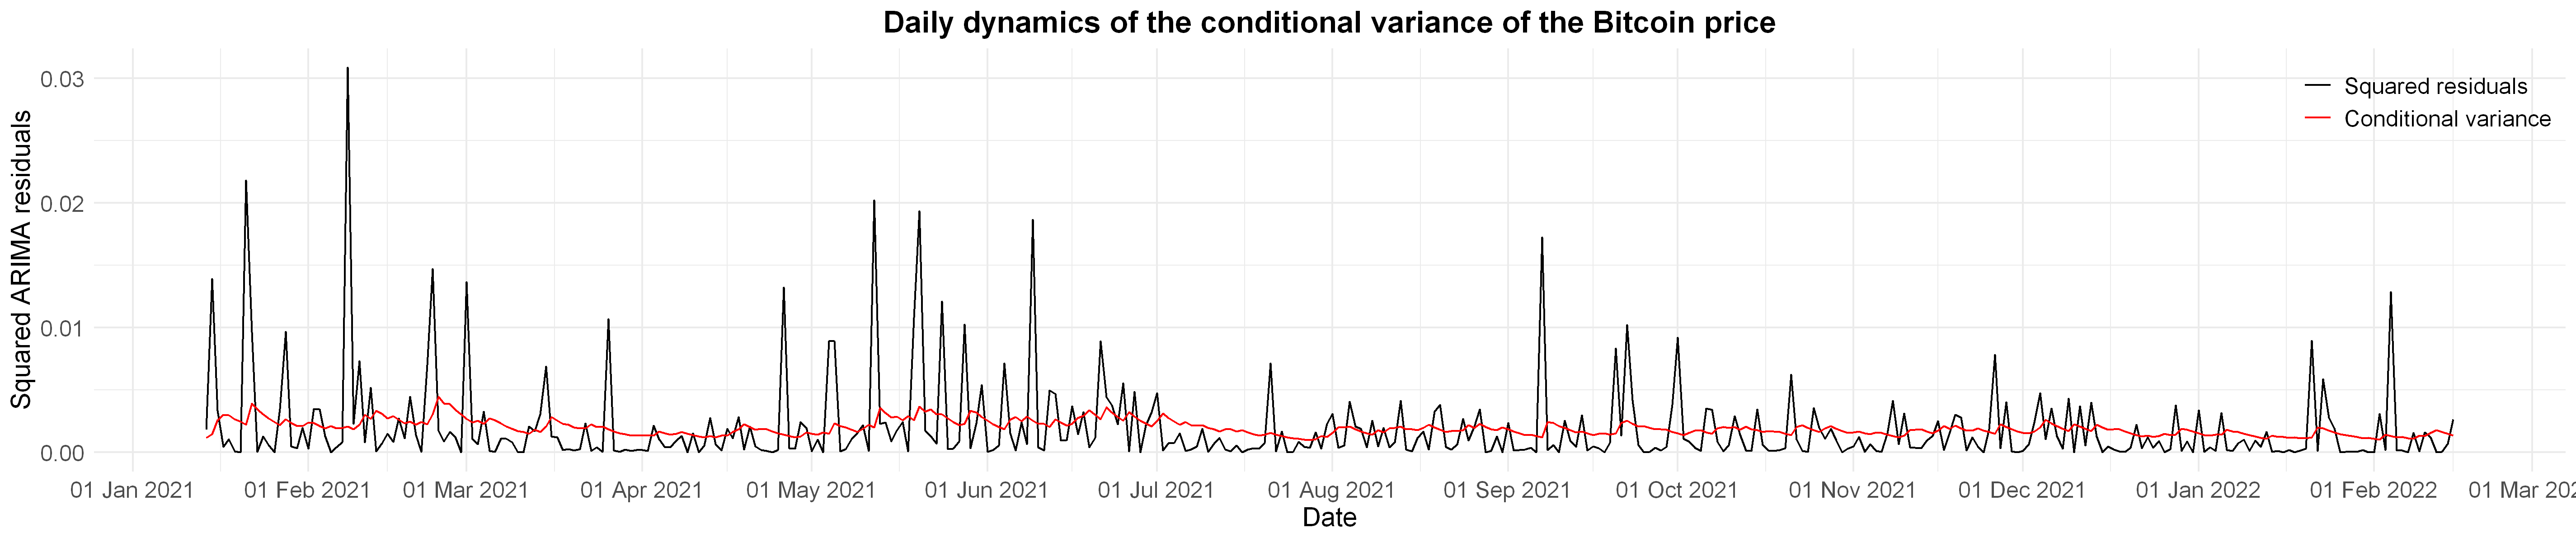

In [89]:
fig(19, 4, 300)
ggplot(BTC_daily[-c(1, 2), ], aes(DATE)) +
    geom_line(aes(y=logretdiff_arima$residuals ^ 2, colour='Squared residuals')) +
    geom_line(aes(y=logretdiff_tgarch@fit$sigma ^ 2, colour='Conditional variance')) +
    # geom_line(aes(y=logretdiff_garch@sigma.t ^ 2), col='#32a852') +
    # geom_line(aes(y=logretdiff_egarch@fit$sigma ^ 2), col='red') +
    xlab('Date') +
    ylab('Squared ARIMA residuals') +
    ggtitle('Daily dynamics of the conditional variance of the Bitcoin price') +
    scale_x_date(date_breaks='1 month',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2021-01-14'), as.Date('2022-02-15'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14),
          legend.text=element_text(size=12),
          legend.justification=c(1, 1),
          legend.position=c(1, 1),
          legend.title=element_blank()) +
    scale_color_manual(name='', values=c('Squared residuals'='black', 'Conditional variance'='red'))

Standardized residuals plot

In [90]:
# garch_std_resid <- logretdiff_arima$residuals / logretdiff_garch@sigma.t
# egarch_std_resid <- logretdiff_arima$residuals / logretdiff_egarch@fit$sigma
tgarch_std_resid <- logretdiff_arima$residuals / logretdiff_tgarch@fit$sigma

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



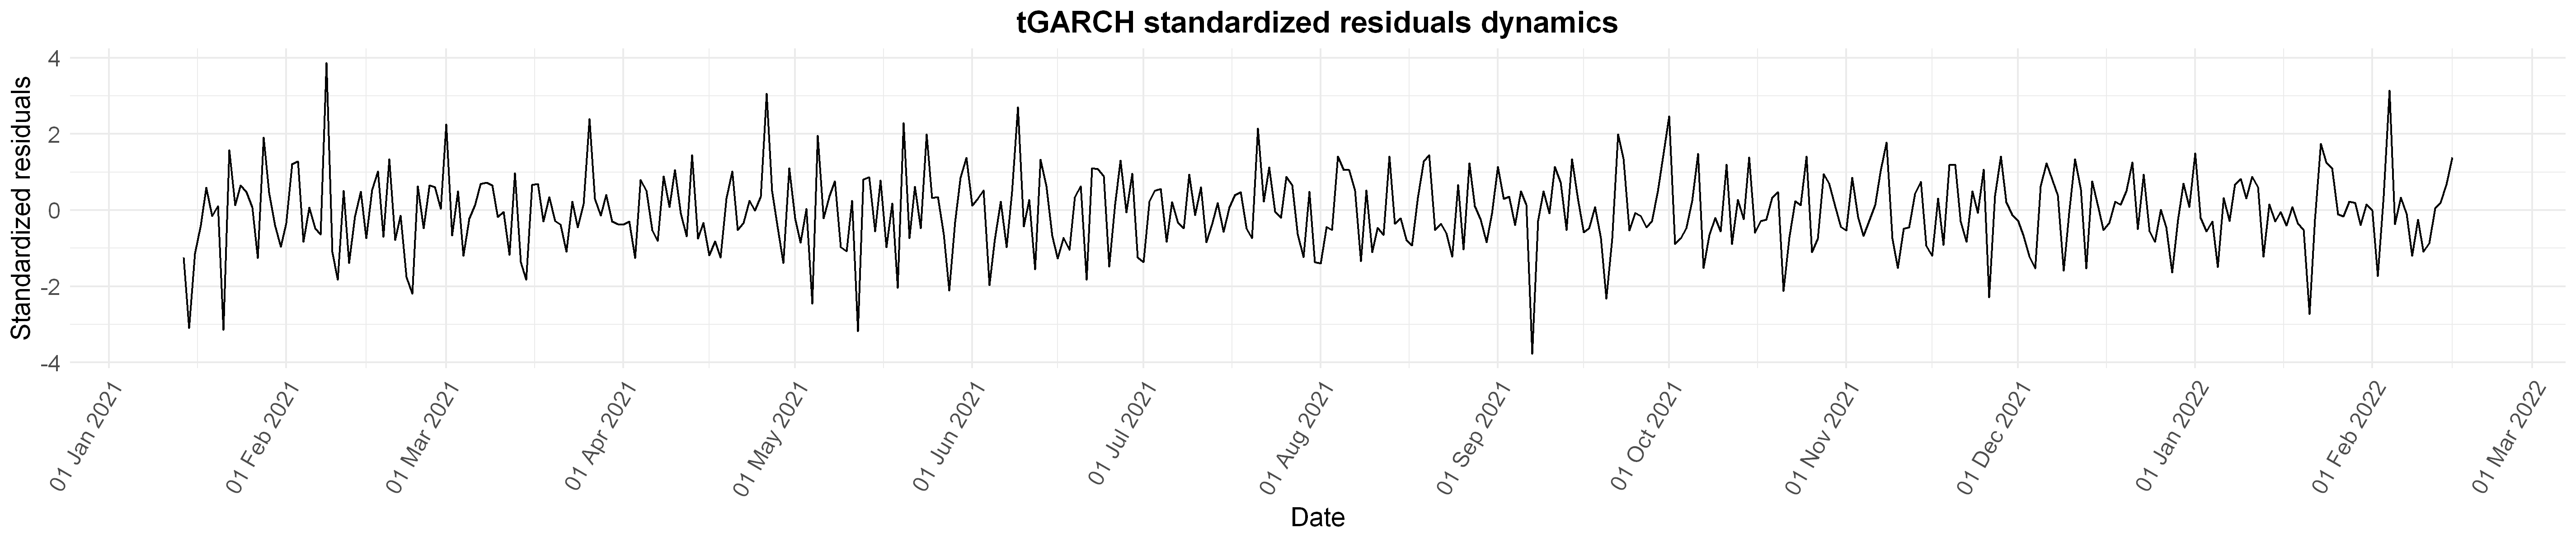

In [91]:
fig(19, 4, 300)
ggplot(BTC_daily[-c(1, 2), ], aes(DATE, tgarch_std_resid)) +
    geom_line() +
    xlab('Date') +
    ylab('Standardized residuals') +
    ggtitle('tGARCH standardized residuals dynamics') +
    scale_x_date(date_breaks='1 month',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2021-01-14'), as.Date('2022-02-15'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(angle=60, hjust=1, size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14))

Let's check the behaviour of standardized residuals series for "white noise"

Main statistical characteristics of standardized residuals

In [92]:
print(describe(tgarch_std_resid))

   vars   n  mean   sd median trimmed  mad   min  max range  skew kurtosis   se
X1    1 398 -0.03 1.01  -0.07   -0.03 0.89 -3.77 3.87  7.64 -0.01     1.17 0.05


Standardized residuals density plot

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



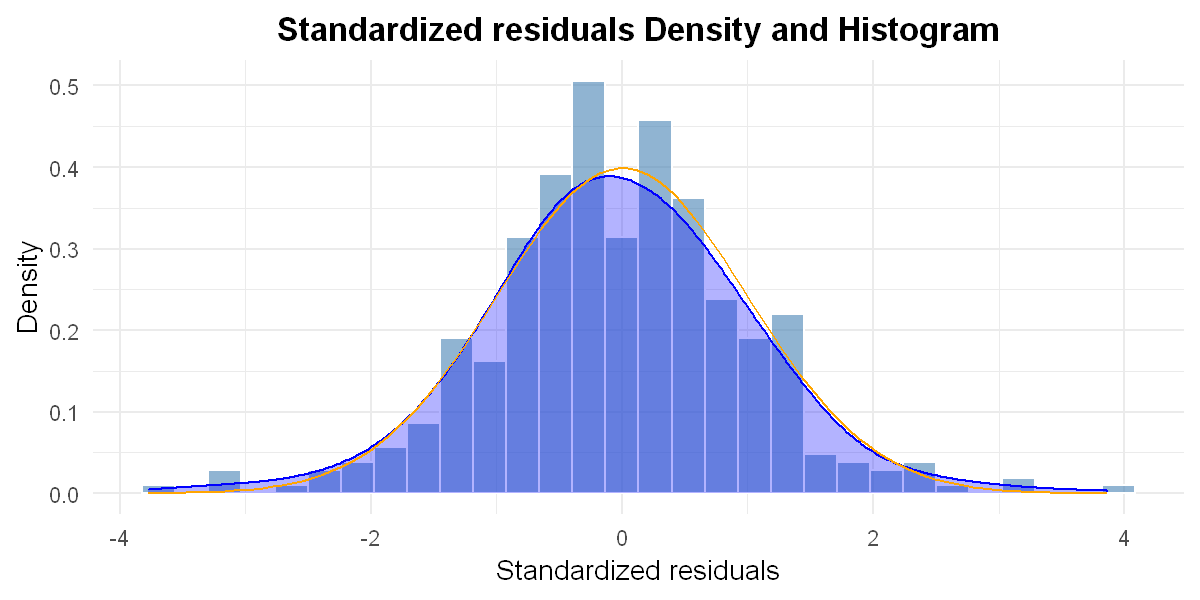

In [93]:
fig(6, 3, 200)
ggplot(BTC_daily[-c(1, 2), ], aes(tgarch_std_resid)) +
    geom_histogram(aes(y=..density..), position='identity', fill='steelblue', col='white', alpha=.6) +
    geom_density(fill='blue', col='blue', alpha=.3, adjust=1.75) +
    stat_function(fun=dnorm, args=list(mean=0, sd=1), col='orange') +
    xlab('Standardized residuals') +
    ylab('Density') +
    ggtitle('Standardized residuals Density and Histogram') +
    theme_minimal() +
    theme(plot.title=element_text(hjust=.5, size=12, face='bold'),
          axis.title=element_text(size=10),
          axis.text.x=element_text(size=8),
          axis.text.y=element_text(size=8))

The distribution of standardized residuals is close to the standard normal distribution.

In [94]:
mean(tgarch_std_resid)  # mean of standardized residuals

[1] -0.034434

In [95]:
sd(tgarch_std_resid)  # standard deviation of standardized residuals

[1] 1.01351

Let's check stationarity conditions using parametric tests

#### 1. Constant variance

##### Fisher's test

In [96]:
var.test(tgarch_std_resid[1:199], tgarch_std_resid[200:398], alternative='two.sided')


	F test to compare two variances

data:  tgarch_std_resid[1:199] and tgarch_std_resid[200:398]
F = 1.2689, num df = 198, denom df = 198, p-value = 0.09467
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.959585 1.677840
sample estimates:
ratio of variances 
           1.26887 


##### Bartlett's test

In [97]:
bartlett.test(list(tgarch_std_resid[1:199], tgarch_std_resid[200:398]))


	Bartlett test of homogeneity of variances

data:  list(tgarch_std_resid[1:199], tgarch_std_resid[200:398])
Bartlett's K-squared = 2.7932, df = 1, p-value = 0.09467


##### Cochran's test

In [98]:
var1 <- var(tgarch_std_resid[1:133])
var2 <- var(tgarch_std_resid[134:266])
var3 <- var(tgarch_std_resid[267:398])
outliers::cochran.test(object=c(var1, var2, var3), data=c(133, 133, 132))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.40819, df = 132.67, k = 3.00, p-value = 0.04393
alternative hypothesis: Group 1 has outlying variance
sample estimates:
        1         2         3 
1.2631095 1.0003536 0.8309274 


All tests allow us to accept the null hypothesis about the constancy of the variance of standardized residuals series.

#### 2. Zero-equal mean

##### Student's t-test

In [99]:
t.test(tgarch_std_resid[1:199], tgarch_std_resid[200:398], alternative='two.sided', var.equal=TRUE)


	Two Sample t-test

data:  tgarch_std_resid[1:199] and tgarch_std_resid[200:398]
t = -0.28253, df = 396, p-value = 0.7777
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2287257  0.1712449
sample estimates:
  mean of x   mean of y 
-0.04880419 -0.02006382 


##### Fisher's test

In [100]:
var1 <- var(tgarch_std_resid[1:133])
var2 <- var(tgarch_std_resid[134:266])
var3 <- var(tgarch_std_resid[267:398])
var_mean <- var(tgarch_std_resid)  # average variance
mean1 <- mean(tgarch_std_resid[1:133])
mean2 <- mean(tgarch_std_resid[134:266])
mean3 <- mean(tgarch_std_resid[267:398])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(tgarch_std_resid)) ^ 2) * c(133, 133, 132)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 398 - 3)
print(F.stat)
print(F.crit)

[1] 0.08329695
[1] 3.723545


Based on the results we can accept the constant mean hypothesis.

#### 3. Uncorrelated residuals

ACF and PACF of absolute values of standardized residuals

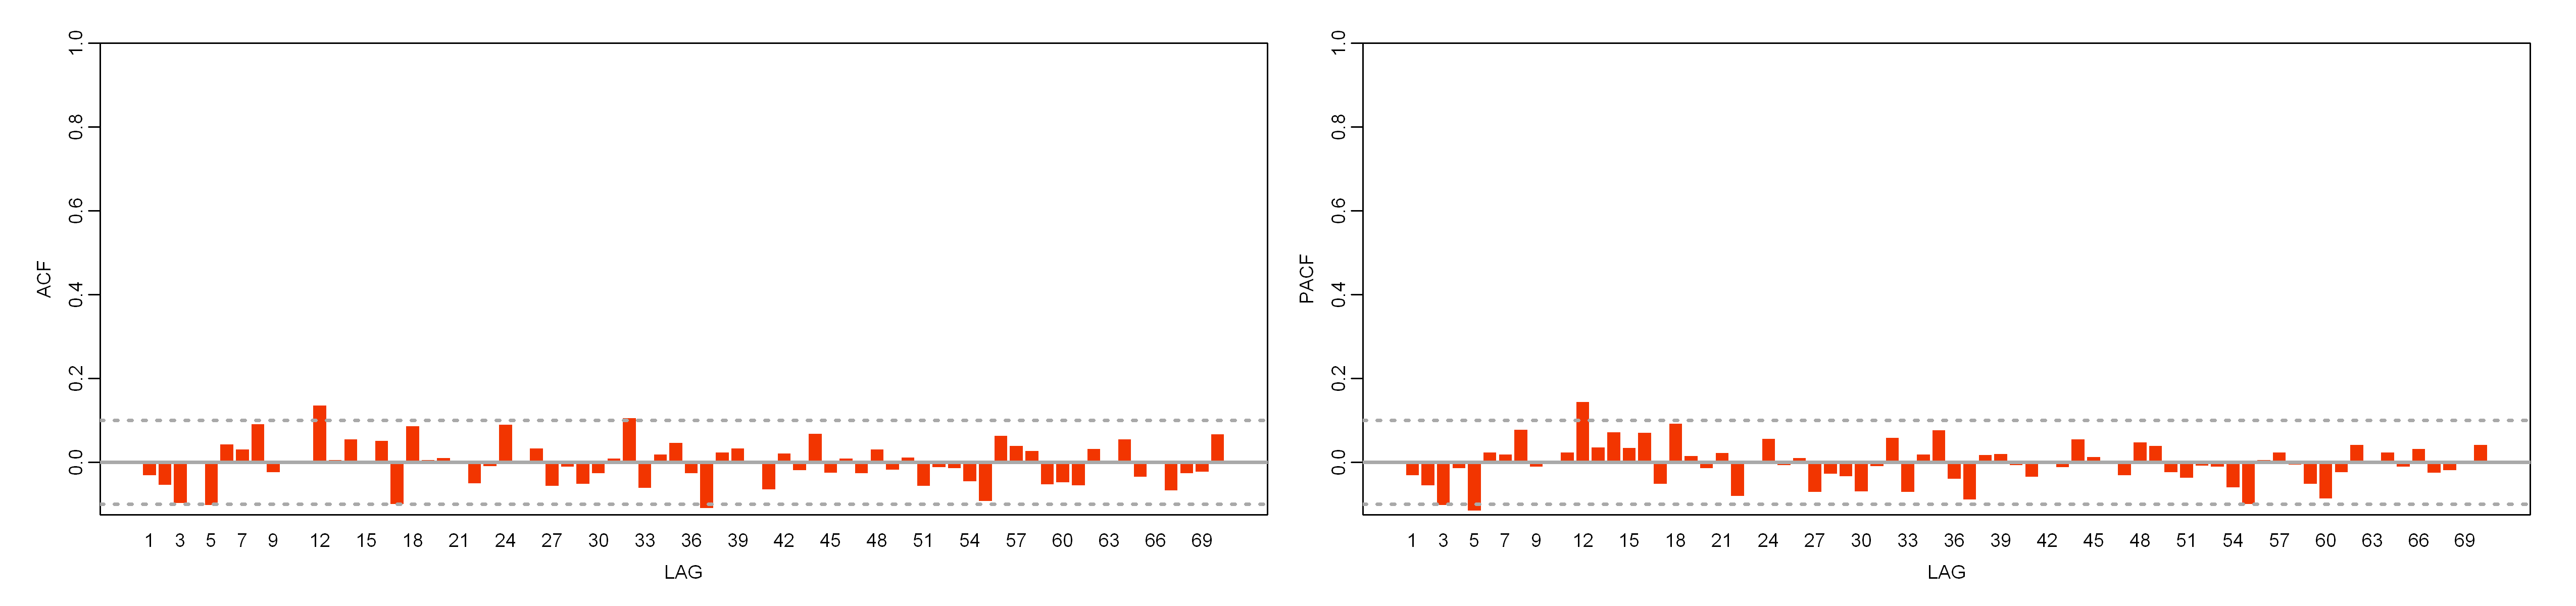

In [101]:
fig(17, 4, 300)
ac(abs(tgarch_std_resid), max.lag=70)

There is a slight deviation from the "white noise" in some lags because we expect 5% of the coefficients for all possible lags to go beyond the border of 95% confidence interval with the true null hypothesis: $ρ_τ = 0$. ACF and PACF don't demonstrate the presence of ARCH-effects in standardized residuals series. To make sure of that, we’ll use the Ljung-Box and Box-Pierce tests

##### Ljung-Box test

In [102]:
Box.test(abs(tgarch_std_resid), lag=15, type='Ljung')


	Box-Ljung test

data:  abs(tgarch_std_resid)
X-squared = 23.17, df = 15, p-value = 0.0806


##### Box-Pierce test

In [103]:
Box.test(abs(tgarch_std_resid), lag=15, type='Box-Pierce')


	Box-Pierce test

data:  abs(tgarch_std_resid)
X-squared = 22.605, df = 15, p-value = 0.0929


The results of both test allows us to accept the no autocorrelation null hypothesis and suggest that the model specification is quite good at capturing ARCH-effects.

### Model undifferencing and forecasting

The undifferenced AR(3) model for the first difference of log-returns series will look like:  
$y ̂_t = e^{α ̂_0} \cdot y^{2 + α ̂_1}_{t-1} \cdot y^{-2α ̂_1+α ̂_2-1}_{t-2} \cdot y^{α ̂_1-2α ̂_2+α ̂_3}_{t-3} \cdot y^{α ̂_2-2α ̂_3}_{t-4} \cdot y^{α ̂_3}_{t-5}$.

In [104]:
arima_fitted <- c(rep(NA, 5), numeric(395))

# undifferencing
for (t in 6:400) {
    arima_fitted[t] <- exp(a_0 + (a_1 + 2) * log(BTC_daily$CBBTCUSD[t - 1]) +
                           (a_2 - 2 * a_1 - 1) * log(BTC_daily$CBBTCUSD[t - 2]) +
                           (a_3 - 2 * a_2 + a_1) * log(BTC_daily$CBBTCUSD[t - 3]) +
                           (a_2 - 2 * a_3) * log(BTC_daily$CBBTCUSD[t - 4]) +
                           a_3 * log(BTC_daily$CBBTCUSD[t - 5]))
}

Let's plot the initial time series values and fitted values

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
"Removed 5 row(s) containing missing values (geom_path)."


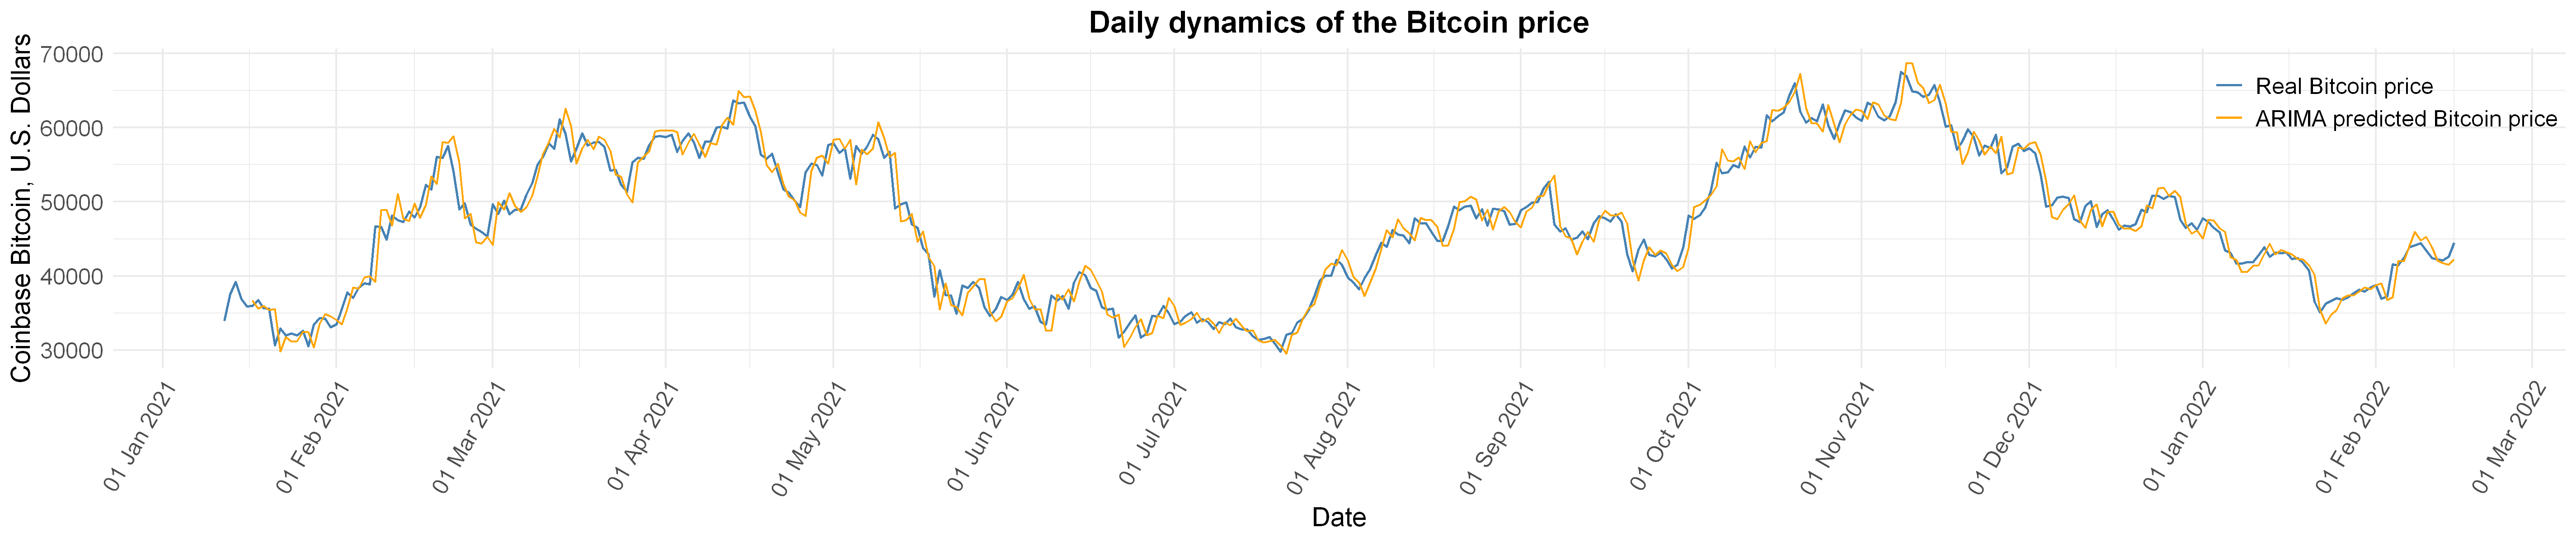

In [105]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=arima_fitted, colour='ARIMA predicted Bitcoin price')) +
    scale_color_manual(name='', values=c('Real Bitcoin price'='steelblue', 'ARIMA predicted Bitcoin price'='orange'))

R-squared

In [106]:
1 - var(BTC_daily$CBBTCUSD[-c(1:5)] - arima_fitted[-c(1:5)]) / var(BTC$CBBTCUSD[-c(1:5)])

[1] 0.9860758

In [107]:
library(MLmetrics)


Attaching package: 'MLmetrics'


The following objects are masked from 'package:DescTools':

    AUC, Gini, MAE, MAPE, MSE, RMSE


The following object is masked from 'package:psych':

    AUC


The following object is masked from 'package:base':

    Recall




In [108]:
paste('MAE', MAE(arima_fitted[6:length(arima_fitted)], y[6:length(y)]))
paste('MAPE', MAPE(arima_fitted[6:length(arima_fitted)], y[6:length(y)]))
paste('MSE', MSE(arima_fitted[6:length(arima_fitted)], y[6:length(y)]))
paste('RMSE', RMSE(arima_fitted[6:length(arima_fitted)], y[6:length(y)]))

[1] "MAE 1573.34707117553"

[1] "MAPE 0.0338269129151277"

[1] "MSE 4165496.09517713"

[1] "RMSE 2040.95470189251"

To do the 2-period point forecast of bitcoin rate we use the following formulas:  
$y ̂_{t+1}=e^{α ̂_0} \cdot y^{2 + α ̂_1}_{t} \cdot y^{-2α ̂_1+α ̂_2-1}_{t-1} \cdot y^{α ̂_1-2α ̂_2+α ̂_3}_{t-2} \cdot y^{α ̂_2-2α ̂_3}_{t-3} \cdot y^{α ̂_3}_{t-4}$,  
$y ̂_{t+2}=e^{\frac{α ̂_0(1-α ̂_1^2-α ̂_1α ̂_2-α ̂_1α ̂_3-α ̂_2-α ̂_3)} {1-α ̂_1-α ̂_2-α ̂_3}} \cdot y ̂_{t+1}^2 \cdot y_t^{α ̂_1^2+α ̂_2-1} \cdot y_{t-1}^{-2α ̂_1^2+α ̂_2(α ̂_1-2)+α ̂_3} \cdot y_{t-2}^{α ̂_1^2-2α ̂_1α ̂_2+α ̂_1α ̂_3+α ̂_2-2α ̂_3} \cdot y_{t-3}^{α ̂_1α ̂_2-2α ̂_1α ̂_3+α ̂_3} \cdot y_{t-4}^{α ̂_1α ̂_3}$.

In [109]:
y <- BTC_daily$CBBTCUSD  # create a variable for more comfortable code writing

Point forecast for the period (t + 1)

In [110]:
BTC_fc1 <- exp(a_0) * y[400] ^ (2 + a_1) *y[399] ^ (-2 * a_1 + a_2 - 1) * y[398] ^ (a_1 - 2 * a_2 + a_3) * y[397] ^ (a_2 - 2 * a_3) * y[396] ^ a_3
BTC_fc1

[1] 44837.28

Point forecast for the period (t + 2)

In [111]:
BTC_fc2 <- exp(a_0 * (1 - a_1 ^ 2 - a_1 * a_2 - a_1 * a_3 - a_2 - a_3) / (1 - a_1 - a_2 - a_3)) * BTC_fc1 ^ 2 * y[400] ^ (a_1 ^ 2 + a_2 - 1) *
       y[399] ^ (-2 * a_1 ^ 2 + a_2 * (a_1 - 2) + a_3) * y[398] ^ (a_1 ^ 2 - 2 * a_1 * a_2 + a_1 * a_3 + a_2 - 2 * a_3) *
       y[397] ^ (a_1 * a_2 - 2 * a_1 * a_3 + a_3) * y[396] ^ (a_1 * a_3)
BTC_fc2

[1] 45475.55

The prediction interval will be carried out using the tGARCH(1, 1) model.    
We will undifference confidence interval boundaries values using formulas:  
$y_{t+1} = y_t^2 \cdot \frac{1} {y_{t-1}} \cdot e^{∆z_{t+1}}$,  
$y_{t+2} = y_t^3 \cdot \frac{1} {y_{t-1}^2} \cdot e^{2∆z_{t+1} + ∆z_{t+2}}$,  
where $∆z_t$ is the series of the first difference of log-returns.

In [112]:
u_a <- qnorm(1 - 0.05 / 2, mean=0, sd=1)
u_a  # standard normal distribution quantile for 0.05 significance level

[1] 1.959964

In [113]:
# msfe_1 <- fGarch::predict(logretdiff_garch, n.ahead=1, mse='cond', plot=FALSE)$standardDeviation[1]
msfe_1 <- ugarchforecast(logretdiff_tgarch)@forecast$sigmaFor[1]
print(msfe_1)  # forecast error for the period (t + 1)

[1] 0.03550524


In [114]:
# msfe_2 <- fGarch::predict(logretdiff_garch, n.ahead=2, mse='cond', plot=FALSE)$standardDeviation[2]
msfe_2 <- ugarchforecast(logretdiff_tgarch)@forecast$sigmaFor[2]
print(msfe_2)  # forecast error for the period (t + 2)

[1] 0.03589513


Interval prediction for the period (t + 1) without undifferencing

In [115]:
logretdiff_fc1 <- forecast::forecast(logretdiff_arima, 2, 0.95)$mean[1]
logretdiff_lower1 <- logretdiff_fc1 - msfe_1 * u_a
logretdiff_upper1 <- logretdiff_fc1 + msfe_1 * u_a
paste(logretdiff_lower1, '  ', logretdiff_upper1)

[1] "-0.105022527513098    0.0341554375509769"

Interval prediction for the period (t + 1) after undifferencing

In [116]:
BTC_lower1 <- y[400]^2 / y[399] * exp(logretdiff_lower1)
BTC_upper1 <- y[400]^2 / y[399] * exp(logretdiff_upper1)

paste(BTC_lower1, BTC_fc1, BTC_upper1)

[1] "41820.4320111479 44837.2838295165 48065.4195009252"

Interval prediction for the period (t + 2) without undifferencing

In [117]:
logretdiff_fc2 <- forecast::forecast(logretdiff_arima, 2, 0.95)$mean[2]
logretdiff_lower2 <- logretdiff_fc2 - msfe_2 * u_a
logretdiff_upper2 <- logretdiff_fc2 + msfe_2 * u_a
paste(logretdiff_lower2, '  ', logretdiff_upper2)

[1] "-0.0644611782543124    0.0762451613497694"

Interval prediction for the period (t + 2) after undifferencing

In [118]:
BTC_lower2 <- y[400]^3 / y[399]^2 * exp(2 * logretdiff_lower1 + logretdiff_lower2)
BTC_upper2 <- y[400]^3 / y[399]^2 * exp(2 * logretdiff_upper1 + logretdiff_upper2)

paste(BTC_lower2, BTC_fc2, BTC_upper2)

[1] "36873.7581626973 45475.5491917216 56067.8411640956"

Let's display forecasted values on the plot and compare them with actual values

In [119]:
BTC_valid <- read.csv('./data/CBBTCUSD_valid.csv')  # loading validation data
BTC_valid <- BTC_valid[1828:1829, ]
BTC_valid['CBBTCUSD'] <- sapply(BTC_valid['CBBTCUSD'], as.numeric)
BTC_valid$DATE <- as.Date(BTC_valid$DATE, format='%Y-%m-%d')
print(BTC_valid)

           DATE CBBTCUSD
1828 2022-02-16 43897.22
1829 2022-02-17 40553.82


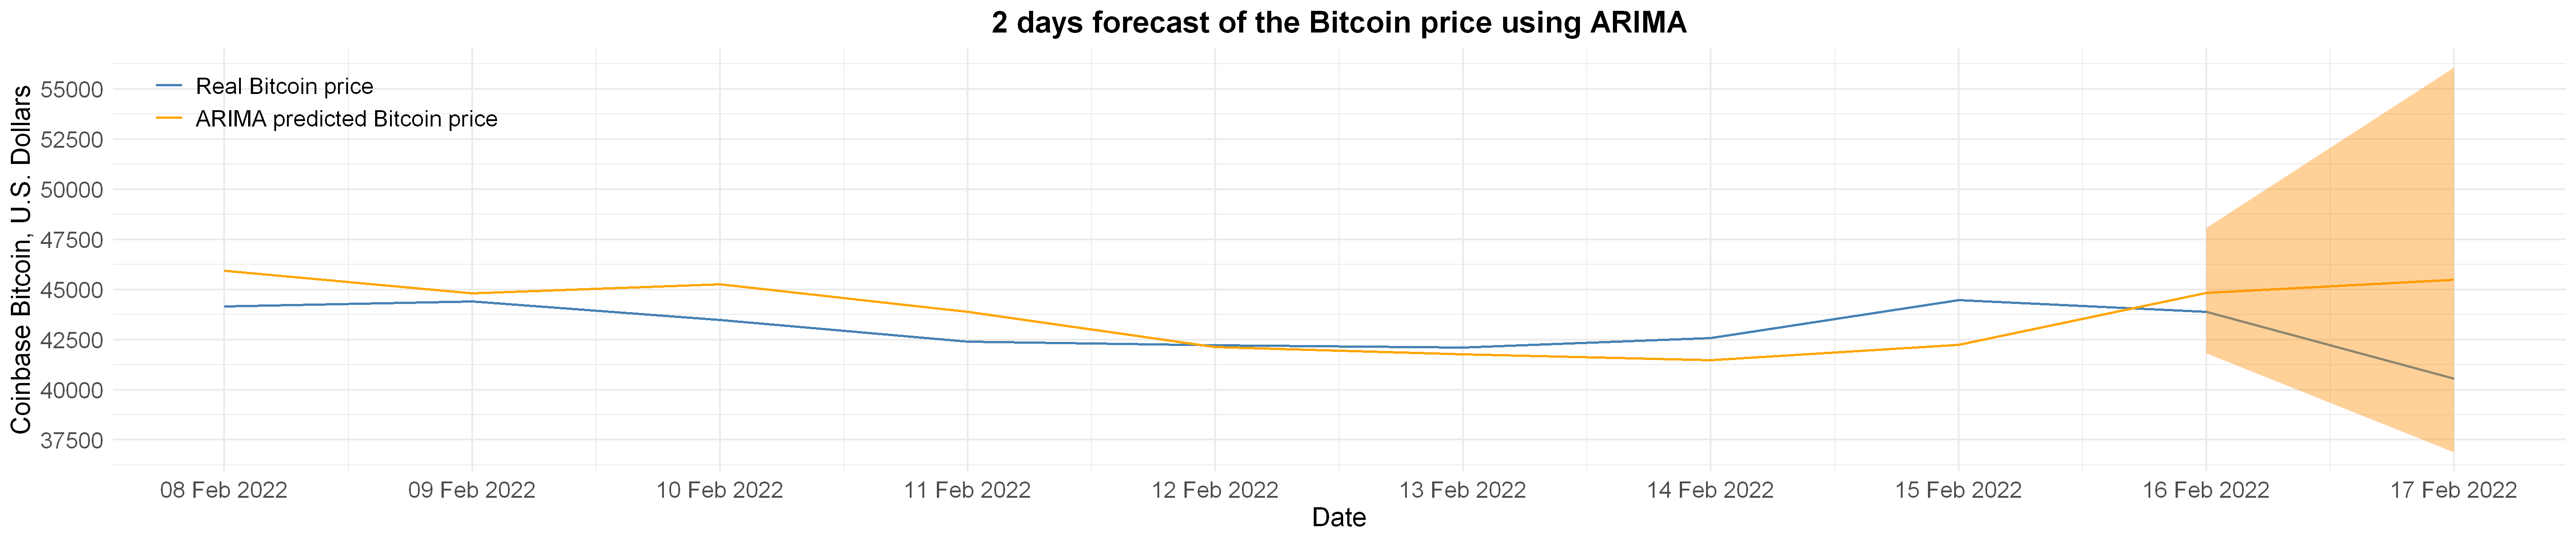

In [120]:
fig(19, 4, 300)
ggplot(rbind(BTC_daily, BTC_valid)[393:402, ], aes(DATE)) +
        geom_line(aes(y=CBBTCUSD, colour='Real Bitcoin price'), size=0.6) +
        geom_line(aes(y=c(arima_fitted[393:400], BTC_fc1, BTC_fc2), colour='ARIMA predicted Bitcoin price'), size=0.6) +
        geom_ribbon(aes(ymin=c(rep(NA, 8), BTC_lower1, BTC_lower2), ymax=c(rep(NA, 8), BTC_upper1, BTC_upper2)), fill='darkorange', alpha=.4) +
        xlab('Date') +
        ylab('Coinbase Bitcoin, U.S. Dollars') +
        ggtitle('2 days forecast of the Bitcoin price using ARIMA') +
        scale_y_continuous(breaks=seq(35000, 57500, 2500),
                           labels=seq(35000, 57500, 2500)) +
        scale_x_date(date_breaks='1 day',
                     date_labels='%d %b %Y',
                     limit=c(as.Date('2022-02-08'), as.Date('2022-02-17'))) +
        theme_minimal() +
        theme(axis.text.x=element_text(size=12),
              axis.text.y=element_text(size=12),
              plot.title=element_text(hjust=.5, size=16, face='bold'),
              axis.title=element_text(size=14),
              legend.text=element_text(size=12),
              legend.justification=c(1, 1),
              legend.position=c(0.16, 1),
              legend.title=element_blank()) +
        scale_color_manual(name='', values=c('Real Bitcoin price'='steelblue', 'ARIMA predicted Bitcoin price'='orange'))

## Part 2. Modelling and forecasting using GRU recurrent neural network

In [2]:
library(knitr)
library(reticulate)
knitr::knit_engines$set(python=reticulate::eng_python)

In [3]:
py_config()

python:         D:/Programs/Python/python.exe
libpython:      D:/Programs/Python/python39.dll
pythonhome:     D:/Programs/Python
version:        3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
Architecture:   64bit
numpy:          D:/Programs/Python/Lib/site-packages/numpy
numpy_version:  1.22.3
tensorflow:     C:\Users\goroh\AppData\Roaming\Python\Python39\site-packages\tensorflow\__init__.p

NOTE: Python version was forced by RETICULATE_PYTHON

In [4]:
sl <- import('sklearn')
library(keras)

In [5]:
train_len <- 1800

In [6]:
train <- BTC[1:train_len, 'CBBTCUSD']
test <- BTC[(train_len + 1):dim(BTC)[1], 'CBBTCUSD']

Data normalization

In [7]:
scaler <- sl$preprocessing$MinMaxScaler(feature_range=tuple(0, 1))

In [8]:
train_scaled <- scaler$fit_transform(train)
test_scaled <- scaler$transform(test)
print(dim(train_scaled))

[1] 1800    1


In [9]:
library(ggfortify)

Loading required package: ggplot2



Creating time series generator

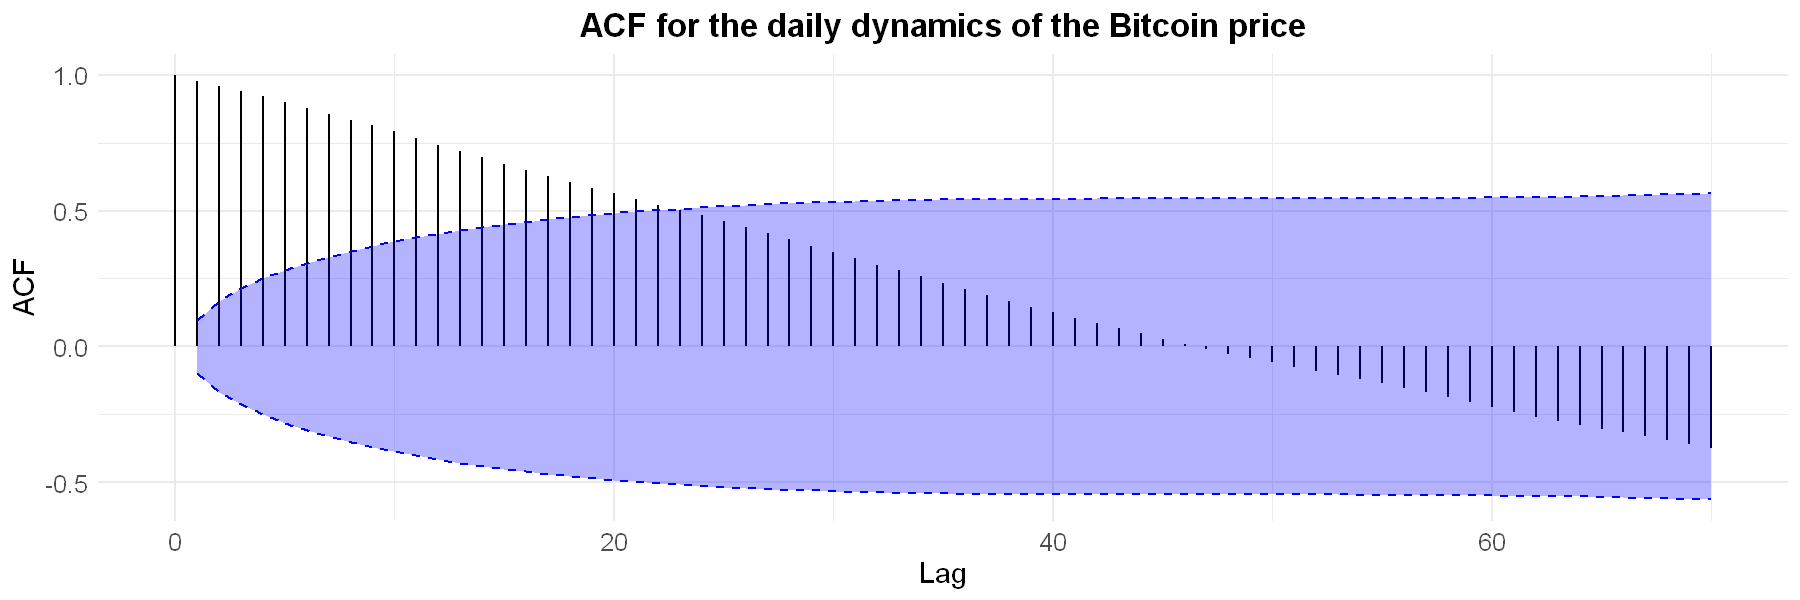

In [10]:
fig(12, 4, 150)
autoplot(acf(BTC_daily$CBBTCUSD, plot=FALSE, lag.max=70),
         conf.int.fill='blue',
         conf.int.colour='blue',
         conf.int.value=.95,
         conf.int.type='ma') +
    ggtitle('ACF for the daily dynamics of the Bitcoin price') +
    theme_minimal() +
    theme(axis.text=element_text(size=12),
          axis.title=element_text(size=14),
          plot.title=element_text(hjust=.5, size=16, face='bold'))

To predict each observation, we will use the history of 22 previous observations.

In [11]:
n_steps_back <- 22

In [12]:
train_generator <- timeseries_generator(data=train_scaled, targets=train_scaled, length=n_steps_back, batch_size=1)

Loaded Tensorflow version 2.10.0-dev20220611



In [13]:
ts <- rbind(train, test)
inputs_test <- ts[(train_len - n_steps_back + 1):length(ts)]  # inputs for prediction of 27 validation observations
inputs_test <- array(inputs_test, dim=c(length(inputs_test), 1))
inputs_test <- scaler$transform(inputs_test)
test_generator <- timeseries_generator(data=inputs_test, targets=inputs_test, length=n_steps_back, batch_size=1)

In [14]:
paste('Given the vector:', train_generator[1][1])
paste('Predict this scalar:', train_generator[1][2])

[1] "Given the vector: c(0.00156319490633905, 0.00183897337410599, 0.00191182328853756, 0.00187772652134299, 0.00232744356617332, 0.00290528638288379, 0.00291159516200423, 0.00378564442507923, 0.00378579460084438, 0.00335154891945422, 0.0037557533942163, 0.00391947804018855, 0.00390851311385632, 0.00443303259089589, 0.00502139003947377, 0.00537722837179899, 0.00509348884224892, 0.00516874250024557, 0.00525901606306434, 0.00454358430579305, 0.00323468842543662, 0.00394185865297914)"

[1] "Predict this scalar: 0.00261568906717002"

In [15]:
dim(train_generator[1][[1]])
dim(train_generator[1][[2]])

[1]  1 22  1

[1] 1 1

Initializing the Recurrent Neural Network

In [16]:
gru_rnn <- keras_model_sequential(input_shape=c(n_steps_back, 1)) %>%
        layer_gru(units=64, return_sequences=TRUE) %>%
        layer_dropout(rate=0.2) %>%
        layer_gru(units=32, return_sequences=TRUE) %>%
        layer_dropout(rate=0.2) %>%
        layer_gru(units=16) %>%
        layer_dense(units=8, activation='tanh') %>%
        layer_dense(units=1, activation='linear')
summary(gru_rnn)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 gru_2 (GRU)                        (None, 22, 64)                  12864       
 dropout_1 (Dropout)                (None, 22, 64)                  0           
 gru_1 (GRU)                        (None, 22, 32)                  9408        
 dropout (Dropout)                  (None, 22, 32)                  0           
 gru (GRU)                          (None, 16)                      2400        
 dense_1 (Dense)                    (None, 8)                       136         
 dense (Dense)                      (None, 1)                       9           
Total params: 24,817
Trainable params: 24,817
Non-trainable params: 0
________________________________________________________________________________


In [17]:
gru_rnn %>% compile(optimizer='adam', loss='mean_squared_error')

In [18]:
callbacks <- callback_early_stopping(monitor='val_loss', patience=10, verbose=1)

Model training

In [19]:
history_gru <- gru_rnn %>% fit(x=train_generator, validation_data=test_generator, epochs=50, batch_size=64, callbacks=callbacks)

In [20]:
history_gru


Final epoch (plot to see history):
    loss: 0.0005949
val_loss: 0.0006859 

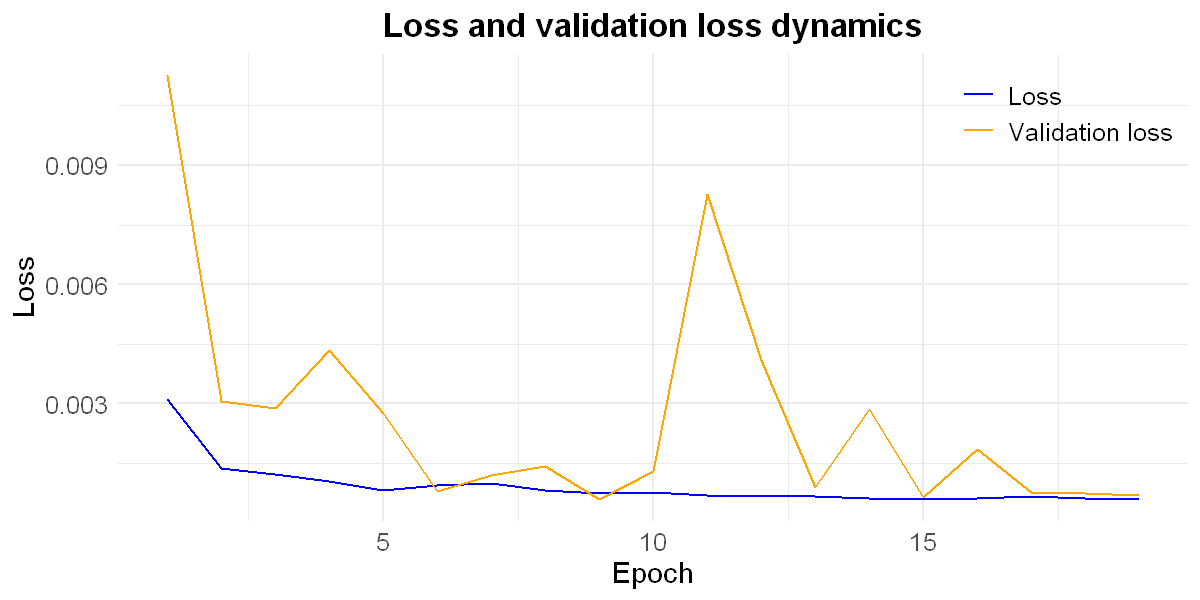

In [21]:
fig(8, 4, 150)
ggplot(data.frame(epoch=1:19, loss=history_gru$metrics$loss, val_loss=history_gru$metrics$val_loss)) +
    geom_line(aes(epoch, loss, colour='Loss')) +
    geom_line(aes(epoch, val_loss, colour='Validation loss')) +
    ggtitle('Loss and validation loss dynamics') +
    xlab('Epoch') +
    ylab('Loss') +
    theme_minimal() +
    theme(axis.text=element_text(size=12),
          axis.title=element_text(size=14),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          legend.text=element_text(size=12),
          legend.justification=c(1, 1),
          legend.position=c(1, 1),
          legend.title=element_blank()) +
    scale_color_manual(name='', values=c('Loss'='blue', 'Validation loss'='orange'))

Model validation

In [22]:
test_pred_gru <- gru_rnn %>% predict(test_generator)
test_pred_gru <- scaler$inverse_transform(test_pred_gru)

In [24]:
paste('MAE', MAE(test_pred_gru, test))
paste('MAPE', MAPE(test_pred_gru, test))
paste('MSE', MSE(test_pred_gru, test))
paste('RMSE', RMSE(test_pred_gru, test))

[1] "MAE 1386.88728273154"

[1] "MAPE 0.0347552802154407"

[1] "MSE 3040155.15502793"

[1] "RMSE 1743.60407060431"

Warning message:
"Removed 201 row(s) containing missing values (geom_path)."


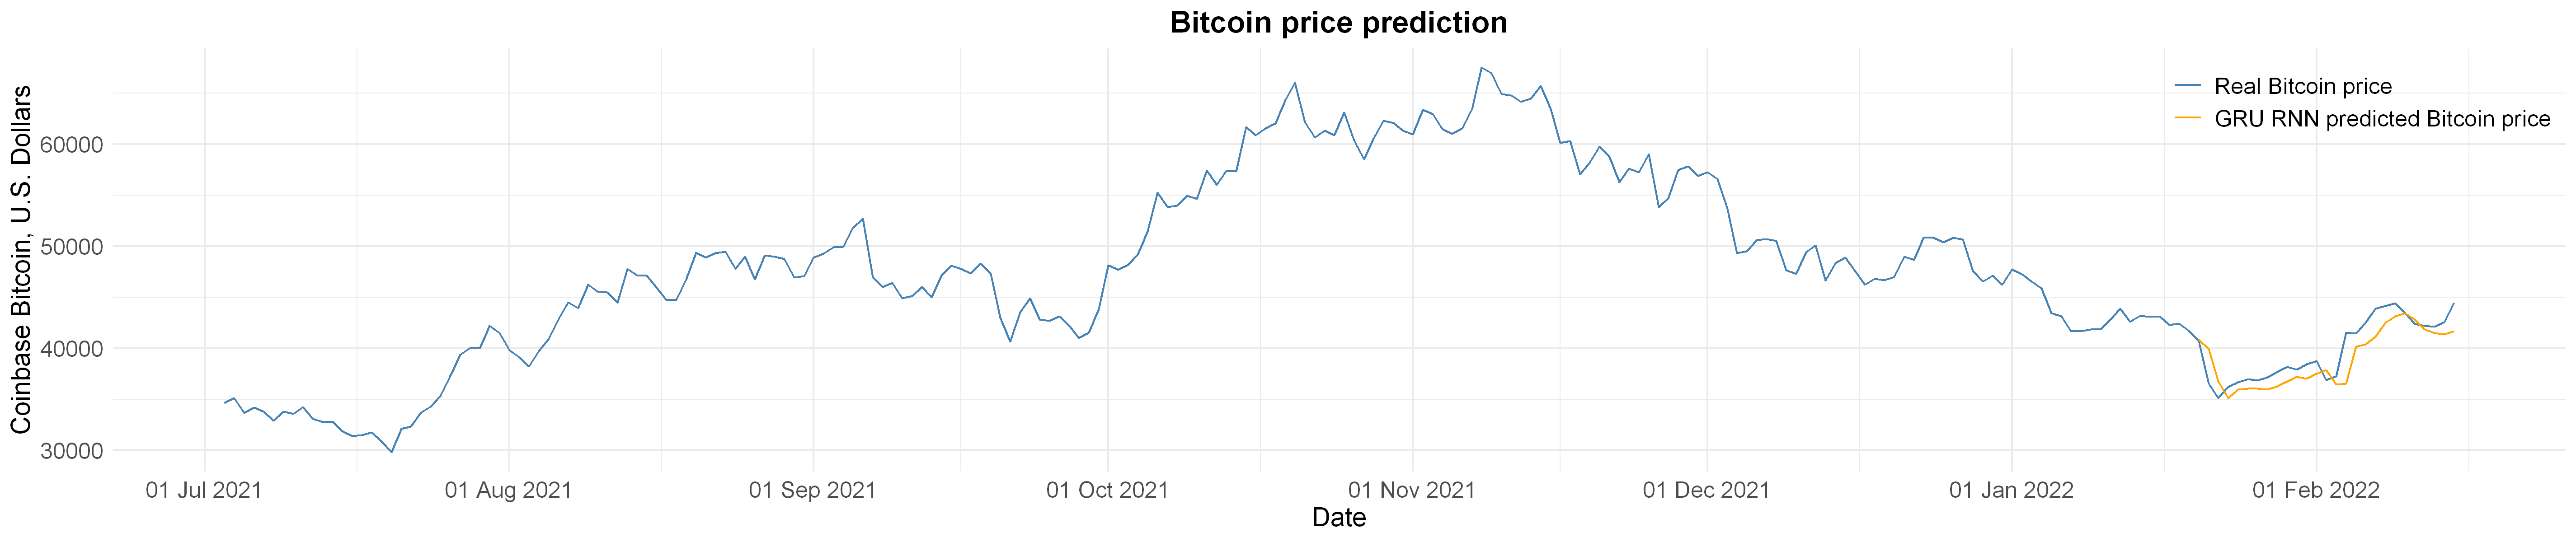

In [25]:
fig(19, 4, 300)
ggplot(BTC[1600:dim(BTC)[1], ], aes(DATE)) +
    geom_line(aes(y=CBBTCUSD, colour='Real Bitcoin price')) +
    geom_line(aes(y=c(rep(NA, length(ts) - 1600 - dim(test_pred_gru)[1] + 1), as.numeric(test_pred_gru)), colour='GRU RNN predicted Bitcoin price')) +
    ggtitle('Bitcoin price prediction') +
    xlab('Date') +
    ylab('Coinbase Bitcoin, U.S. Dollars') +
    scale_x_date(date_breaks='1 month',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2021-07-03'), as.Date('2022-02-15'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14),
          legend.text=element_text(size=12),
          legend.justification=c(1, 1),
          legend.position=c(1, 1),
          legend.title=element_blank()) +
    scale_color_manual(name='', values=c('Real Bitcoin price'='steelblue', 'GRU RNN predicted Bitcoin price'='orange'))

In general, the resulting model can be used for forecasting.

Saving model

In [26]:
save_model_tf(gru_rnn, './keras_model/')

2 days prediction

In [27]:
library(abind)

In [28]:
inputs <- ts[(length(ts) - n_steps_back + 1):length(ts)]
inputs <- scaler$transform(array_reshape(inputs, c(length(inputs), 1)))
inputs <- array_reshape(inputs, c(1, n_steps_back, 1))
outputs <- numeric()

for (i in 1:2) {
    pred <- gru_rnn %>% predict(inputs)
    outputs <- c(outputs, as.numeric(scaler$inverse_transform(pred)))
    inputs <- abind(array(inputs[1, 2:dim(inputs)[2], 1], c(1, n_steps_back - 1, 1)), array_reshape(pred, c(1, 1, 1)), along=2)
}

In [29]:
outputs

[1] 43130.10 42337.43

Let's display forecasted values on the plot and compare them with actual values

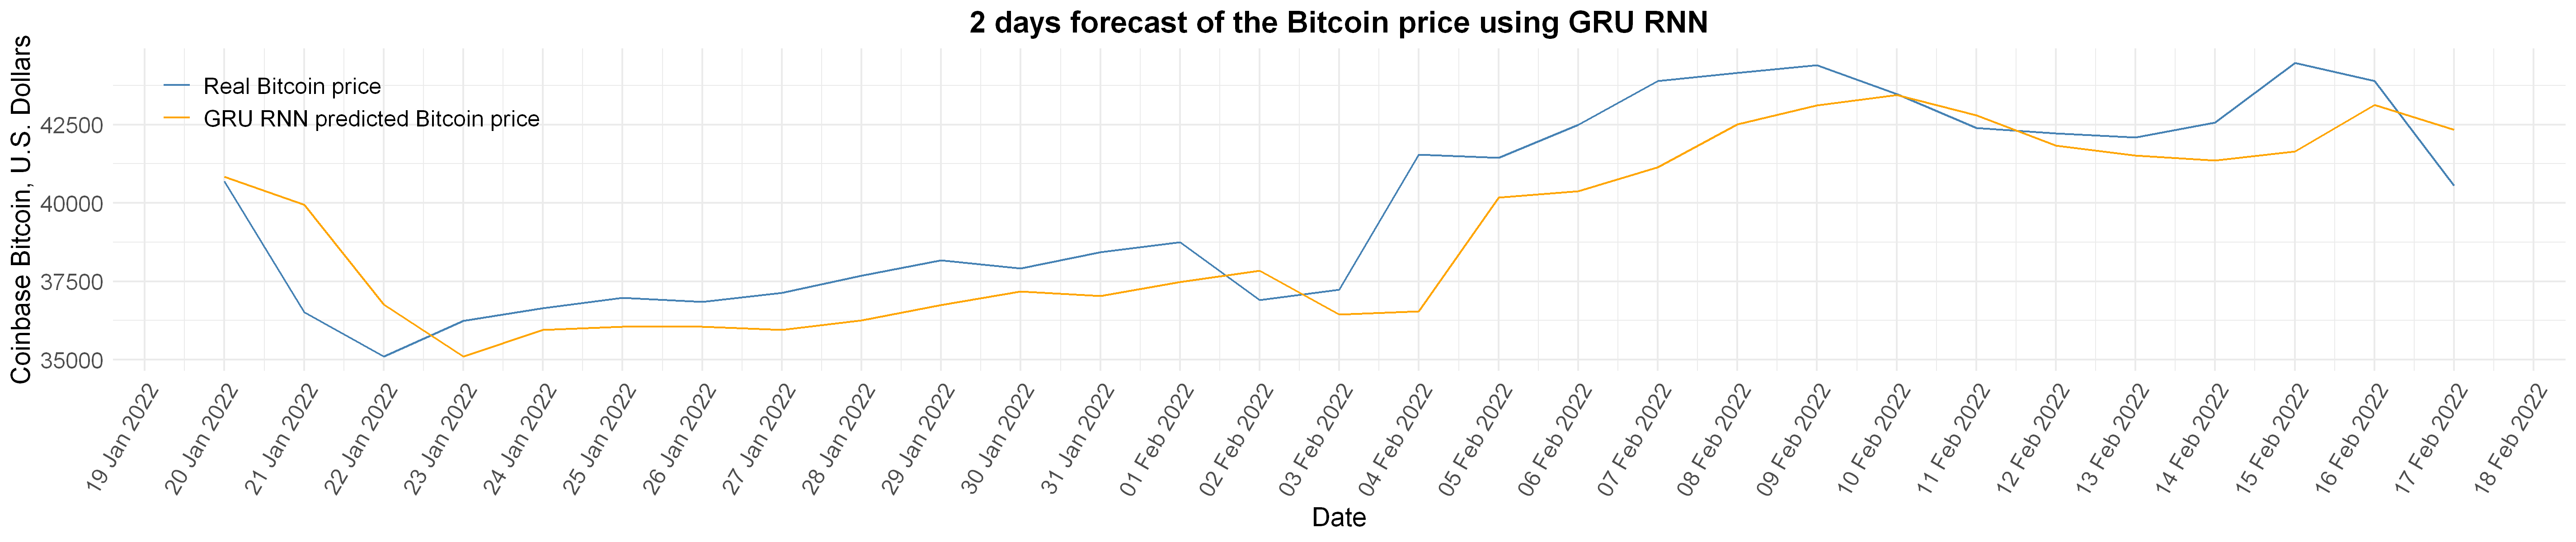

In [30]:
fig(19, 4, 300)
ggplot(rbind(BTC[1801:dim(BTC)[1], ], BTC_valid), aes(DATE)) +
    geom_line(aes(y=CBBTCUSD, colour='Real Bitcoin price')) +
    geom_line(aes(y=c(as.numeric(test_pred_gru), outputs), colour='GRU RNN predicted Bitcoin price')) +
    ggtitle('2 days forecast of the Bitcoin price using GRU RNN') +
    xlab('Date') +
    ylab('Coinbase Bitcoin, U.S. Dollars') +
    scale_x_date(date_breaks='1 day',
                 date_labels='%d %b %Y',
                 limit=c(as.Date('2022-01-20'), as.Date('2022-02-17'))) +
    theme_minimal() +
    theme(axis.text.x=element_text(angle=60, hjust=1, size=12),
          axis.text.y=element_text(size=12),
          plot.title=element_text(hjust=.5, size=16, face='bold'),
          axis.title=element_text(size=14),
          legend.text=element_text(size=12),
          legend.justification=c(1, 1),
          legend.position=c(0.18, 1),
          legend.title=element_blank()) +
    scale_color_manual(name='', values=c('Real Bitcoin price'='steelblue', 'GRU RNN predicted Bitcoin price'='orange'))

In [31]:
save.image('./case_BTC.RData')

##### Conclusion

The ARIMA-GARCH models are a good tool for financial time series prediction. The advantage of using the above models is possibility to easily obtain not only the point forecast, but also the interval forecast. A challenge is that it might need careful data analysis and pre-processing.
The GRU-based recurrent neural networks also might be a good choice. The advantage is that they do not rely on specific assumptions about the data such as time series stationarity. Challenges are that they require careful hyperparameter selection, and that it is difficult to obtain interval predictions.